In [116]:
# -*- coding: utf-8 -*-

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import time
import math
import random
import pandas as pd
import scipy.signal
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.distributions as dist
from trajectory_dataPrepare8 import *

torch.manual_seed(0)

MAX_LENGTH = 100
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print('ok')
length = 100
predict_length=30
Training_generator, Test, Valid, WholeSet= get_dataloader(128,length,predict_length)
print(len(WholeSet))
class NNPred(nn.Module):
    def __init__(self, input_size, output_size,hidden_size,batch_size, dropout=0.5):
        super(NNPred, self).__init__()
        
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layers = 2

        self.in2lstm = nn.Linear(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size,num_layers=self.num_layers,bidirectional=False,batch_first=True,dropout =dropout)
        self.in2bilstm = nn.Linear(input_size, hidden_size)
        self.bilstm = nn.LSTM(hidden_size, hidden_size//2,num_layers=self.num_layers,bidirectional=True,batch_first=True,dropout =dropout)
    
        self.fc0 = nn.Linear(hidden_size,hidden_size*2)
        self.fc1 = nn.Linear(hidden_size*2,int(hidden_size/2))
        self.in2out = nn.Linear(input_size, int(hidden_size/2))
        self.fc2 = nn.Linear(int(hidden_size/2) ,output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, input):
        #input = tensor shape[batchsize, len, num_features]
        bilstm_out,_= self.bilstm(self.in2bilstm(input))
        lstm_out,_= self.lstm(self.in2lstm(input))
        out = self.tanh(self.fc0(lstm_out+bilstm_out))
        out = self.tanh(self.fc1(out))
        out =  out + self.in2out(input)
        output = self.fc2(out)# range [0 -> 1 ]
        return output


ok
****************************** ——-————-————-————-————-————-————-————-————-————-————-————-————-————-————-————-————-————-————-————-—— ******************************
---轨迹输入数据结构： torch.Size([128, 100, 26]) ---轨迹输出数据结构： torch.Size([128, 100, 4]) --行为输入数据结构
---轨迹长度： 100 ---预测轨迹长度： 30
17320


In [117]:
import  torch
import numpy as np
f = [[[2,3],[4,5],[4,6]]]
d = [[[1,1,1]]]
print(np.array(f).shape,np.array(d).shape)
g = torch.tensor(d).bmm(torch.tensor(f))
h = torch.tensor([[[1,1]]])
print(g)
print(h+g)

(1, 3, 2) (1, 1, 3)
tensor([[[10, 14]]])
tensor([[[11, 15]]])


In [118]:
a = np.array([[[1,2],[2,3]]])
print(a.shape,a*a)

(1, 2, 2) [[[1 4]
  [4 9]]]


In [119]:
def trainIters(encoder, epoches,learning_rate=0.0001,print_every=7):
    # print_loss_total = 0  # Reset every print_every
 #  plot_loss_total = 0  # Reset every plot_every
    #criterion = nn.SmoothL1Loss()
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer,mode='min',factor=0.1,
patience=120,verbose=True,threshold=0.0001,threshold_mode='rel',cooldown=0,min_lr=0,eps=1e-015)
    #criterion = nn.MSELoss(reduction='sum')
    criterion = nn.MSELoss()
    loss_min = np.inf
    train_losses =[]
    valid_losses =[]
    encoder.train()
    for e in range(1, epoches + 1):
        train_loss = []
        for batch_i,(local_batch, local_labels) in enumerate(Training_generator):
            #if local_batch.shape[0]!=BatchSize:
             #   continue
            encoder.zero_grad()
            local_batch = local_batch[:,:,:-1].to(device)
            local_labels = local_labels.to(device)
            
            predY = encoder(local_batch)
            loss = criterion(predY,local_labels).to(device)
            loss.backward()
            encoder_optimizer.step()
            train_loss.append(loss.item())
            if batch_i % print_every == 0:     
                valid_loss = []
                encoder.eval()
                for x,y in Valid:
                    x,y = x[:,:,:-1].to(device),y.to(device)
                    predict = encoder(x)
                    loss_valid = criterion(predict,y)
                    valid_loss.append(loss_valid.item())
                encoder.train()
                train_loss_mean = np.mean(train_loss)
                valid_loss_mean = np.mean(valid_loss)
                train_losses.append(train_loss_mean)
                valid_losses.append(valid_loss_mean)
                scheduler.step(valid_loss_mean)
                print("Epoch:{}/{},Step:{}/{}".format(e,epoches,batch_i,len(Training_generator)),
                  "Train_Loss:{},Valid_Loss: {}".format(train_loss_mean,valid_loss_mean))
                if valid_loss_mean < loss_min :                             
                    print("valid_loss decrease!!!save the model.")
                    loss_min = valid_loss_mean
                    torch.save(encoder.state_dict(),'model/trajectory_predict_25_4_30.pt')
                #torch.save(encoder.state_dict(),'model/trajectory_predict_68_4_30_each.pt')
    plt.plot(train_losses,color = 'r',label = 'Train_Loss')
    plt.plot(valid_losses,color = 'g',label = 'Valid_Loss')
    plt.title('Loss_Trend')
    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    #plt.title('损失变化')
    #plt.xlabel('迭代次数')
    #plt.ylabel('损失大小')
    plt.legend()
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.savefig('image/trajectory_loss_improve1_25_4_30.svg',dpi=600)
    plt.savefig('image/trajectory_loss_improve1_25_4_30.png',dpi=600)

In [120]:
train_iter = iter(Training_generator)
x, y= train_iter.next()
print(x.shape,y.shape)
hidden_size = 256
Prednet = NNPred(x.shape[2]-1, y.shape[2],hidden_size, x.shape[0])

torch.Size([128, 100, 26]) torch.Size([128, 100, 4])


Epoch:1/1000,Step:0/109 Train_Loss:0.10058803878012805,Valid_Loss: 0.5146131740055319
valid_loss decrease!!!save the model.
Epoch:1/1000,Step:20/109 Train_Loss:0.18920854908922616,Valid_Loss: 0.09281478356608619
valid_loss decrease!!!save the model.
Epoch:1/1000,Step:40/109 Train_Loss:0.1492809803384529,Valid_Loss: 0.08955479204312763
valid_loss decrease!!!save the model.
Epoch:1/1000,Step:60/109 Train_Loss:0.1635160002632238,Valid_Loss: 0.08776372205313511
valid_loss decrease!!!save the model.
Epoch:1/1000,Step:80/109 Train_Loss:0.1469691772421487,Valid_Loss: 0.08557510599760751
valid_loss decrease!!!save the model.
Epoch:1/1000,Step:100/109 Train_Loss:0.13606697449939353,Valid_Loss: 0.08524714155508221
valid_loss decrease!!!save the model.
Epoch:2/1000,Step:0/109 Train_Loss:0.09237141752644355,Valid_Loss: 0.08611146270432656
Epoch:2/1000,Step:20/109 Train_Loss:0.12233468833403881,Valid_Loss: 0.08806203203522742
Epoch:2/1000,Step:40/109 Train_Loss:0.10721825156531323,Valid_Loss: 0.087

Epoch:16/1000,Step:0/109 Train_Loss:0.08544130603960517,Valid_Loss: 0.08688239456147274
Epoch:16/1000,Step:20/109 Train_Loss:0.12105911576573625,Valid_Loss: 0.09157720364935731
Epoch:16/1000,Step:40/109 Train_Loss:0.10322314252483714,Valid_Loss: 0.08695175688076053
Epoch:16/1000,Step:60/109 Train_Loss:0.10575546062475488,Valid_Loss: 0.08549156866950945
Epoch:16/1000,Step:80/109 Train_Loss:0.10834173685689603,Valid_Loss: 0.0861885734023028
Epoch:16/1000,Step:100/109 Train_Loss:0.10354229389725893,Valid_Loss: 0.08415013976601915
valid_loss decrease!!!save the model.
Epoch:17/1000,Step:0/109 Train_Loss:0.071438649006143,Valid_Loss: 0.08528950494219886
Epoch:17/1000,Step:20/109 Train_Loss:0.082637752040147,Valid_Loss: 0.08540958313266782
Epoch:17/1000,Step:40/109 Train_Loss:0.08266746549278925,Valid_Loss: 0.08486531167347869
Epoch:17/1000,Step:60/109 Train_Loss:0.09145754378467609,Valid_Loss: 0.08520560980355855
Epoch:17/1000,Step:80/109 Train_Loss:0.08955174855741548,Valid_Loss: 0.0842850

Epoch:30/1000,Step:80/109 Train_Loss:0.09400745160371014,Valid_Loss: 0.08547148976019112
Epoch:30/1000,Step:100/109 Train_Loss:0.09759313805831553,Valid_Loss: 0.0826050150730755
Epoch:31/1000,Step:0/109 Train_Loss:0.07240106762798248,Valid_Loss: 0.08079262876899364
Epoch:31/1000,Step:20/109 Train_Loss:0.07797919427115611,Valid_Loss: 0.0830890203949155
Epoch:31/1000,Step:40/109 Train_Loss:0.0777356259865396,Valid_Loss: 0.08418897145198671
Epoch:31/1000,Step:60/109 Train_Loss:0.09015547694222713,Valid_Loss: 0.08357494780114236
Epoch:31/1000,Step:80/109 Train_Loss:0.09416221862002114,Valid_Loss: 0.08504318105597322
Epoch:31/1000,Step:100/109 Train_Loss:0.09723945830446686,Valid_Loss: 0.08423890753855792
Epoch:32/1000,Step:0/109 Train_Loss:0.07703158057076263,Valid_Loss: 0.0836049789591665
Epoch:32/1000,Step:20/109 Train_Loss:0.0777100840576584,Valid_Loss: 0.08275063565125965
Epoch:32/1000,Step:40/109 Train_Loss:0.11226899615990758,Valid_Loss: 0.08301533512318593
Epoch:32/1000,Step:60/109 

Epoch:45/1000,Step:100/109 Train_Loss:0.09027183126280575,Valid_Loss: 0.08215074688658884
Epoch:46/1000,Step:0/109 Train_Loss:0.06997418115146034,Valid_Loss: 0.08046672669063391
Epoch:46/1000,Step:20/109 Train_Loss:0.07741888109953143,Valid_Loss: 0.08061215141069386
Epoch:46/1000,Step:40/109 Train_Loss:0.07610548518361604,Valid_Loss: 0.07906410734670999
Epoch:46/1000,Step:60/109 Train_Loss:0.086585741486211,Valid_Loss: 0.07910490410727004
Epoch:46/1000,Step:80/109 Train_Loss:0.08407013529014018,Valid_Loss: 0.07987470411270811
Epoch:46/1000,Step:100/109 Train_Loss:0.08817225376581327,Valid_Loss: 0.0797187970654214
Epoch:47/1000,Step:0/109 Train_Loss:0.07361035523423066,Valid_Loss: 0.08194926169347334
Epoch:47/1000,Step:20/109 Train_Loss:0.0771277436162533,Valid_Loss: 0.080763192181175
Epoch:47/1000,Step:40/109 Train_Loss:0.09209858952850311,Valid_Loss: 0.0815070925173622
Epoch:47/1000,Step:60/109 Train_Loss:0.09866500955399901,Valid_Loss: 0.08093217841332463
Epoch:47/1000,Step:80/109 Tr

Epoch:61/1000,Step:20/109 Train_Loss:0.07369203540049026,Valid_Loss: 0.07948639034949133
Epoch:61/1000,Step:40/109 Train_Loss:0.07408901056012138,Valid_Loss: 0.07891943758972113
Epoch:61/1000,Step:60/109 Train_Loss:0.09557843806583922,Valid_Loss: 0.07910873949787763
Epoch:61/1000,Step:80/109 Train_Loss:0.08961476696844303,Valid_Loss: 0.0778295173075718
Epoch:61/1000,Step:100/109 Train_Loss:0.09282441526877025,Valid_Loss: 0.07703430109528342
valid_loss decrease!!!save the model.
Epoch:62/1000,Step:0/109 Train_Loss:0.07085851056117512,Valid_Loss: 0.07983418816739285
Epoch:62/1000,Step:20/109 Train_Loss:0.0734609901665911,Valid_Loss: 0.08113771476040557
Epoch:62/1000,Step:40/109 Train_Loss:0.09201801790121097,Valid_Loss: 0.07727252197017195
Epoch:62/1000,Step:60/109 Train_Loss:0.09669328872766658,Valid_Loss: 0.07829613343229694
Epoch:62/1000,Step:80/109 Train_Loss:0.09787819140175641,Valid_Loss: 0.07944158219074823
Epoch:62/1000,Step:100/109 Train_Loss:0.09352885046544382,Valid_Loss: 0.08

Epoch:75/1000,Step:100/109 Train_Loss:0.09037810240552531,Valid_Loss: 0.07586897203570427
Epoch:76/1000,Step:0/109 Train_Loss:0.07570216469712104,Valid_Loss: 0.07609437910449736
Epoch:76/1000,Step:20/109 Train_Loss:0.0716084125944145,Valid_Loss: 0.07500123111285846
Epoch:76/1000,Step:40/109 Train_Loss:0.07079475300415042,Valid_Loss: 0.07635692201109882
Epoch:76/1000,Step:60/109 Train_Loss:0.07042148842978894,Valid_Loss: 0.07475628111235604
Epoch:76/1000,Step:80/109 Train_Loss:0.08814655632531275,Valid_Loss: 0.07572062734865105
Epoch:76/1000,Step:100/109 Train_Loss:0.08496672403198972,Valid_Loss: 0.07671740754383742
Epoch:77/1000,Step:0/109 Train_Loss:0.07792393840762225,Valid_Loss: 0.07798342077145103
Epoch:77/1000,Step:20/109 Train_Loss:0.0714082891644222,Valid_Loss: 0.07505992311446696
Epoch:77/1000,Step:40/109 Train_Loss:0.08773048794630535,Valid_Loss: 0.07405544368923016
valid_loss decrease!!!save the model.
Epoch:77/1000,Step:60/109 Train_Loss:0.09064286726932459,Valid_Loss: 0.075

Epoch:90/1000,Step:100/109 Train_Loss:0.0883334508669645,Valid_Loss: 0.07559594187643348
Epoch:91/1000,Step:0/109 Train_Loss:0.06804994973929776,Valid_Loss: 0.07407590998280585
Epoch:91/1000,Step:20/109 Train_Loss:0.10397115750997811,Valid_Loss: 0.07234767130869287
Epoch:91/1000,Step:40/109 Train_Loss:0.08600648384790069,Valid_Loss: 0.07345783595649036
Epoch:91/1000,Step:60/109 Train_Loss:0.08000153406629981,Valid_Loss: 0.07259199797140939
Epoch:91/1000,Step:80/109 Train_Loss:0.09234314725877839,Valid_Loss: 0.07360337032388277
Epoch:91/1000,Step:100/109 Train_Loss:0.08765636626223434,Valid_Loss: 0.07232411262016299
Epoch:92/1000,Step:0/109 Train_Loss:0.06789498445386755,Valid_Loss: 0.07241921872737525
Epoch:92/1000,Step:20/109 Train_Loss:0.06837695291809445,Valid_Loss: 0.0729087909828584
Epoch:92/1000,Step:40/109 Train_Loss:0.08680431315224718,Valid_Loss: 0.07352446369763764
Epoch:92/1000,Step:60/109 Train_Loss:0.08042227040283352,Valid_Loss: 0.07268330238026076
Epoch:92/1000,Step:80/1

Epoch:105/1000,Step:100/109 Train_Loss:0.08557446178364633,Valid_Loss: 0.07195204036805024
Epoch:106/1000,Step:0/109 Train_Loss:0.07261782659678945,Valid_Loss: 0.07246682345033932
Epoch:106/1000,Step:20/109 Train_Loss:0.09450339690447059,Valid_Loss: 0.07064213451264995
Epoch:106/1000,Step:40/109 Train_Loss:0.09580931226656399,Valid_Loss: 0.07075523207873509
Epoch:106/1000,Step:60/109 Train_Loss:0.08625453420313627,Valid_Loss: 0.06881512405777805
valid_loss decrease!!!save the model.
Epoch:106/1000,Step:80/109 Train_Loss:0.08063377091860364,Valid_Loss: 0.0697660130143112
Epoch:106/1000,Step:100/109 Train_Loss:0.0849820060840871,Valid_Loss: 0.06955243802899426
Epoch:107/1000,Step:0/109 Train_Loss:0.07173648911140894,Valid_Loss: 0.0701440374627643
Epoch:107/1000,Step:20/109 Train_Loss:0.12677308452388913,Valid_Loss: 0.06985462138722597
Epoch:107/1000,Step:40/109 Train_Loss:0.09647644829655676,Valid_Loss: 0.07022919524481615
Epoch:107/1000,Step:60/109 Train_Loss:0.09655363512909737,Valid_L

Epoch:120/1000,Step:40/109 Train_Loss:0.06341595854868559,Valid_Loss: 0.0663596729134527
Epoch:120/1000,Step:60/109 Train_Loss:0.07195970752221773,Valid_Loss: 0.06590404381639543
Epoch:120/1000,Step:80/109 Train_Loss:0.06920722863843534,Valid_Loss: 0.0661980638667741
Epoch:120/1000,Step:100/109 Train_Loss:0.07418863430178832,Valid_Loss: 0.06662126698925526
Epoch:121/1000,Step:0/109 Train_Loss:0.06376068961436916,Valid_Loss: 0.0666009915663603
Epoch:121/1000,Step:20/109 Train_Loss:0.09293360623914436,Valid_Loss: 0.06675242362746263
Epoch:121/1000,Step:40/109 Train_Loss:0.07711755118240417,Valid_Loss: 0.06679576131799381
Epoch:121/1000,Step:60/109 Train_Loss:0.0927818829526311,Valid_Loss: 0.06711848465466119
Epoch:121/1000,Step:80/109 Train_Loss:0.08533789260386938,Valid_Loss: 0.06519453621068295
valid_loss decrease!!!save the model.
Epoch:121/1000,Step:100/109 Train_Loss:0.08145192061809346,Valid_Loss: 0.06718408802565022
Epoch:122/1000,Step:0/109 Train_Loss:0.05676963388092347,Valid_Lo

Epoch:134/1000,Step:100/109 Train_Loss:0.07682525858774462,Valid_Loss: 0.061949329490353186
Epoch:135/1000,Step:0/109 Train_Loss:0.05490826633541683,Valid_Loss: 0.061232185427599964
valid_loss decrease!!!save the model.
Epoch:135/1000,Step:20/109 Train_Loss:0.057844049298862533,Valid_Loss: 0.06078751152959243
valid_loss decrease!!!save the model.
Epoch:135/1000,Step:40/109 Train_Loss:0.07212516135358792,Valid_Loss: 0.06179451936682047
Epoch:135/1000,Step:60/109 Train_Loss:0.06676864233534746,Valid_Loss: 0.061431429890382125
Epoch:135/1000,Step:80/109 Train_Loss:0.07235674216735229,Valid_Loss: 0.062430806410075576
Epoch:135/1000,Step:100/109 Train_Loss:0.07655493952066121,Valid_Loss: 0.06038197626398111
valid_loss decrease!!!save the model.
Epoch:136/1000,Step:0/109 Train_Loss:0.06082814287574949,Valid_Loss: 0.06070142330582161
Epoch:136/1000,Step:20/109 Train_Loss:0.05731786773303952,Valid_Loss: 0.0605962621134581
Epoch:136/1000,Step:40/109 Train_Loss:0.05766308576845214,Valid_Loss: 0.

Epoch:148/1000,Step:100/109 Train_Loss:0.06319122271273497,Valid_Loss: 0.05442892862113961
Epoch:149/1000,Step:0/109 Train_Loss:0.04676222942027643,Valid_Loss: 0.05544213961426848
Epoch:149/1000,Step:20/109 Train_Loss:0.04956311358267703,Valid_Loss: 0.05401790171476291
Epoch:149/1000,Step:40/109 Train_Loss:0.06802232430374323,Valid_Loss: 0.05444719471574892
Epoch:149/1000,Step:60/109 Train_Loss:0.08089085204327286,Valid_Loss: 0.052927710258614966
valid_loss decrease!!!save the model.
Epoch:149/1000,Step:80/109 Train_Loss:0.07325653029912582,Valid_Loss: 0.053168527090853616
Epoch:149/1000,Step:100/109 Train_Loss:0.0688870066210322,Valid_Loss: 0.05385975445222158
Epoch:150/1000,Step:0/109 Train_Loss:0.04690240034235114,Valid_Loss: 0.05385470174713482
Epoch:150/1000,Step:20/109 Train_Loss:0.049666992699398685,Valid_Loss: 0.05512313313554828
Epoch:150/1000,Step:40/109 Train_Loss:0.06585705011014688,Valid_Loss: 0.05388729613583615
Epoch:150/1000,Step:60/109 Train_Loss:0.08119632281919469,Va

Epoch:163/1000,Step:20/109 Train_Loss:0.04603830924892927,Valid_Loss: 0.050580234447361046
Epoch:163/1000,Step:40/109 Train_Loss:0.07651659167493517,Valid_Loss: 0.05269477078918985
Epoch:163/1000,Step:60/109 Train_Loss:0.07689731102810005,Valid_Loss: 0.05057759518228545
Epoch:163/1000,Step:80/109 Train_Loss:0.06961525988371595,Valid_Loss: 0.050519606319793416
Epoch:163/1000,Step:100/109 Train_Loss:0.06495147216089403,Valid_Loss: 0.05053244505498084
Epoch:164/1000,Step:0/109 Train_Loss:0.04636900947381253,Valid_Loss: 0.049363308146133364
Epoch:164/1000,Step:20/109 Train_Loss:0.04623686681727163,Valid_Loss: 0.048057070125117694
valid_loss decrease!!!save the model.
Epoch:164/1000,Step:40/109 Train_Loss:0.04592900730003507,Valid_Loss: 0.0490142774121616
Epoch:164/1000,Step:60/109 Train_Loss:0.06576581147819345,Valid_Loss: 0.04840452210636853
Epoch:164/1000,Step:80/109 Train_Loss:0.06095313567880886,Valid_Loss: 0.050165633066156554
Epoch:164/1000,Step:100/109 Train_Loss:0.06368326445433613

Epoch:177/1000,Step:40/109 Train_Loss:0.0691661842399175,Valid_Loss: 0.0467990909198556
Epoch:177/1000,Step:60/109 Train_Loss:0.05979603363359458,Valid_Loss: 0.04312625161554671
Epoch:177/1000,Step:80/109 Train_Loss:0.05449518494786504,Valid_Loss: 0.04480475197389622
Epoch:177/1000,Step:100/109 Train_Loss:0.05720774738478234,Valid_Loss: 0.042559761307953935
Epoch:178/1000,Step:0/109 Train_Loss:0.0400494713820852,Valid_Loss: 0.041895841704814106
valid_loss decrease!!!save the model.
Epoch:178/1000,Step:20/109 Train_Loss:0.038306409093092714,Valid_Loss: 0.04183978598584017
valid_loss decrease!!!save the model.
Epoch:178/1000,Step:40/109 Train_Loss:0.05045916328228361,Valid_Loss: 0.04192892499069395
Epoch:178/1000,Step:60/109 Train_Loss:0.05767249467936602,Valid_Loss: 0.04144764883102043
valid_loss decrease!!!save the model.
Epoch:178/1000,Step:80/109 Train_Loss:0.05299918070753548,Valid_Loss: 0.042034178974053114
Epoch:178/1000,Step:100/109 Train_Loss:0.05608638671806569,Valid_Loss: 0.04

Epoch:191/1000,Step:80/109 Train_Loss:0.04950612530593638,Valid_Loss: 0.038344989120356485
Epoch:191/1000,Step:100/109 Train_Loss:0.05214847382633578,Valid_Loss: 0.0390907725934173
Epoch:192/1000,Step:0/109 Train_Loss:0.03592550770359595,Valid_Loss: 0.03826478262053092
Epoch:192/1000,Step:20/109 Train_Loss:0.033549494723441875,Valid_Loss: 0.03809894745828636
Epoch:192/1000,Step:40/109 Train_Loss:0.04598067412462702,Valid_Loss: 0.03803658649742544
Epoch:192/1000,Step:60/109 Train_Loss:0.04221341012075965,Valid_Loss: 0.038726104179755375
Epoch:192/1000,Step:80/109 Train_Loss:0.04022130061325306,Valid_Loss: 0.04018040938856223
Epoch:192/1000,Step:100/109 Train_Loss:0.05175458896700532,Valid_Loss: 0.037574690616601666
Epoch:193/1000,Step:0/109 Train_Loss:0.03509991517730475,Valid_Loss: 0.037590796560806876
Epoch:193/1000,Step:20/109 Train_Loss:0.061240850095917676,Valid_Loss: 0.03798707249627473
Epoch:193/1000,Step:40/109 Train_Loss:0.059383388174808815,Valid_Loss: 0.038073893913835644
Epo

Epoch:206/1000,Step:0/109 Train_Loss:0.030088983172562877,Valid_Loss: 0.03592562642503958
Epoch:206/1000,Step:20/109 Train_Loss:0.02996309125388552,Valid_Loss: 0.034074730644991995
Epoch:206/1000,Step:40/109 Train_Loss:0.029963866801589828,Valid_Loss: 0.03364848754432576
Epoch:206/1000,Step:60/109 Train_Loss:0.029849887960064124,Valid_Loss: 0.03447212247360996
Epoch:206/1000,Step:80/109 Train_Loss:0.03857718499492678,Valid_Loss: 0.035422188721770075
Epoch:206/1000,Step:100/109 Train_Loss:0.04179846607184518,Valid_Loss: 0.03540869273377869
Epoch:207/1000,Step:0/109 Train_Loss:0.03364428912350426,Valid_Loss: 0.035080082118452253
Epoch:207/1000,Step:20/109 Train_Loss:0.03197125151068362,Valid_Loss: 0.03513191627933949
Epoch:207/1000,Step:40/109 Train_Loss:0.07298279113092973,Valid_Loss: 0.034372310759697884
Epoch:207/1000,Step:60/109 Train_Loss:0.0592850317324105,Valid_Loss: 0.034086723633960155
Epoch:207/1000,Step:80/109 Train_Loss:0.052301130279434206,Valid_Loss: 0.03511821539712168
Epo

Epoch:220/1000,Step:60/109 Train_Loss:0.026346642197845837,Valid_Loss: 0.02972399332806133
Epoch:220/1000,Step:80/109 Train_Loss:0.03316085466839145,Valid_Loss: 0.030016661337552975
Epoch:220/1000,Step:100/109 Train_Loss:0.04287901064797454,Valid_Loss: 0.031044131093270755
Epoch:221/1000,Step:0/109 Train_Loss:0.02771042743332059,Valid_Loss: 0.030879586062425714
Epoch:221/1000,Step:20/109 Train_Loss:0.026184435088304984,Valid_Loss: 0.03130644587200556
Epoch:221/1000,Step:40/109 Train_Loss:0.026490413677743425,Valid_Loss: 0.030186850935642946
Epoch:221/1000,Step:60/109 Train_Loss:0.034055757433915985,Valid_Loss: 0.030906215615337965
Epoch:221/1000,Step:80/109 Train_Loss:0.03226840850803801,Valid_Loss: 0.03087356325636612
Epoch:221/1000,Step:100/109 Train_Loss:0.042897985717443535,Valid_Loss: 0.0310897144217858
Epoch:222/1000,Step:0/109 Train_Loss:0.02634879433743,Valid_Loss: 0.03028401208388443
Epoch:222/1000,Step:20/109 Train_Loss:0.049456710503319776,Valid_Loss: 0.030665148439761335
Ep

Epoch:235/1000,Step:40/109 Train_Loss:0.024138239552884355,Valid_Loss: 0.029291507269651764
Epoch:235/1000,Step:60/109 Train_Loss:0.032943585087464054,Valid_Loss: 0.028899323413665152
Epoch:235/1000,Step:80/109 Train_Loss:0.0439080543076827,Valid_Loss: 0.027201929417588974
Epoch:235/1000,Step:100/109 Train_Loss:0.04001311626198605,Valid_Loss: 0.0281100801111433
Epoch:236/1000,Step:0/109 Train_Loss:0.021959284513517183,Valid_Loss: 0.028223535571722056
Epoch:236/1000,Step:20/109 Train_Loss:0.04617917929216666,Valid_Loss: 0.028988644855026845
Epoch:236/1000,Step:40/109 Train_Loss:0.050716604644332766,Valid_Loss: 0.028173729429270346
Epoch:236/1000,Step:60/109 Train_Loss:0.04221742616104369,Valid_Loss: 0.029027872210939387
Epoch:236/1000,Step:80/109 Train_Loss:0.03764760116582242,Valid_Loss: 0.02874558737925258
Epoch:236/1000,Step:100/109 Train_Loss:0.04039344085647191,Valid_Loss: 0.027924041708211323
Epoch:237/1000,Step:0/109 Train_Loss:0.025023570488735478,Valid_Loss: 0.0281795235036553


Epoch:250/1000,Step:0/109 Train_Loss:0.02172585732611573,Valid_Loss: 0.026401960081660424
Epoch:250/1000,Step:20/109 Train_Loss:0.021679171818381814,Valid_Loss: 0.02548496268847682
valid_loss decrease!!!save the model.
Epoch:250/1000,Step:40/109 Train_Loss:0.021873376821625413,Valid_Loss: 0.02586336374376514
Epoch:250/1000,Step:60/109 Train_Loss:0.03200092463360358,Valid_Loss: 0.025995055076452358
Epoch:250/1000,Step:80/109 Train_Loss:0.03598754269066154,Valid_Loss: 0.02770130160206254
Epoch:250/1000,Step:100/109 Train_Loss:0.03769393469929124,Valid_Loss: 0.026241970469072316
Epoch:251/1000,Step:0/109 Train_Loss:0.021101035954681838,Valid_Loss: 0.0259945395655349
Epoch:251/1000,Step:20/109 Train_Loss:0.021572190456867563,Valid_Loss: 0.025161127722948064
valid_loss decrease!!!save the model.
Epoch:251/1000,Step:40/109 Train_Loss:0.03656161506687541,Valid_Loss: 0.02662568768726648
Epoch:251/1000,Step:60/109 Train_Loss:0.03170154570466697,Valid_Loss: 0.0259855271130342
Epoch:251/1000,Step

Epoch:264/1000,Step:40/109 Train_Loss:0.03365406140184084,Valid_Loss: 0.026345352786838073
Epoch:264/1000,Step:60/109 Train_Loss:0.036364897074940394,Valid_Loss: 0.024405092140674926
Epoch:264/1000,Step:80/109 Train_Loss:0.03221548300199089,Valid_Loss: 0.023646976024520455
Epoch:264/1000,Step:100/109 Train_Loss:0.029818825790931442,Valid_Loss: 0.023650469570147836
Epoch:265/1000,Step:0/109 Train_Loss:0.020885832817975257,Valid_Loss: 0.025767830495204005
Epoch:265/1000,Step:20/109 Train_Loss:0.02009889242061597,Valid_Loss: 0.02384233679886644
Epoch:265/1000,Step:40/109 Train_Loss:0.03481757770153253,Valid_Loss: 0.02461576756761288
Epoch:265/1000,Step:60/109 Train_Loss:0.02979027767389469,Valid_Loss: 0.02356053792054676
valid_loss decrease!!!save the model.
Epoch:265/1000,Step:80/109 Train_Loss:0.03372430409511861,Valid_Loss: 0.023712650320190192
Epoch:265/1000,Step:100/109 Train_Loss:0.035316211849842905,Valid_Loss: 0.024156427754488573
Epoch:266/1000,Step:0/109 Train_Loss:0.02070943289

Epoch:278/1000,Step:100/109 Train_Loss:0.03418746874999583,Valid_Loss: 0.022443477312492955
Epoch:279/1000,Step:0/109 Train_Loss:0.017440431575243664,Valid_Loss: 0.022615910205345525
Epoch:279/1000,Step:20/109 Train_Loss:0.04756683365926205,Valid_Loss: 0.022219803854536424
Epoch:279/1000,Step:40/109 Train_Loss:0.04604758185542619,Valid_Loss: 0.02381757805562303
Epoch:279/1000,Step:60/109 Train_Loss:0.0441686554573225,Valid_Loss: 0.022355045057991702
Epoch:279/1000,Step:80/109 Train_Loss:0.03786657101260137,Valid_Loss: 0.021935879162877425
Epoch:279/1000,Step:100/109 Train_Loss:0.03410938166722787,Valid_Loss: 0.021481164375070413
valid_loss decrease!!!save the model.
Epoch:280/1000,Step:0/109 Train_Loss:0.01777229150005526,Valid_Loss: 0.02243116958566913
Epoch:280/1000,Step:20/109 Train_Loss:0.04733248825808417,Valid_Loss: 0.022832387665608942
Epoch:280/1000,Step:40/109 Train_Loss:0.033734864458884996,Valid_Loss: 0.023562679915485846
Epoch:280/1000,Step:60/109 Train_Loss:0.0372049195373

Epoch:293/1000,Step:60/109 Train_Loss:0.04289246398448009,Valid_Loss: 0.02272748033157507
Epoch:293/1000,Step:80/109 Train_Loss:0.036912015768812,Valid_Loss: 0.022401788193132655
Epoch:293/1000,Step:100/109 Train_Loss:0.03321358120278657,Valid_Loss: 0.02212446447591745
Epoch:294/1000,Step:0/109 Train_Loss:0.01763200805197562,Valid_Loss: 0.02187372142052751
Epoch:294/1000,Step:20/109 Train_Loss:0.018711408393480913,Valid_Loss: 0.021731812896499697
Epoch:294/1000,Step:40/109 Train_Loss:0.018641773775310146,Valid_Loss: 0.022948279024624128
Epoch:294/1000,Step:60/109 Train_Loss:0.028099247546291898,Valid_Loss: 0.02128374659672368
Epoch:294/1000,Step:80/109 Train_Loss:0.025540033278158302,Valid_Loss: 0.020600917033488264
valid_loss decrease!!!save the model.
Epoch:294/1000,Step:100/109 Train_Loss:0.032857947063116476,Valid_Loss: 0.0226407981980297
Epoch:295/1000,Step:0/109 Train_Loss:0.017430089919153957,Valid_Loss: 0.022392542747345562
Epoch:295/1000,Step:20/109 Train_Loss:0.01848128086880

Epoch:308/1000,Step:20/109 Train_Loss:0.017124292712971268,Valid_Loss: 0.021045802487274824
Epoch:308/1000,Step:40/109 Train_Loss:0.030602150017403264,Valid_Loss: 0.02074664047964354
Epoch:308/1000,Step:60/109 Train_Loss:0.033930512600676435,Valid_Loss: 0.02000849462418221
Epoch:308/1000,Step:80/109 Train_Loss:0.03480566511561801,Valid_Loss: 0.02149972914877165
Epoch:308/1000,Step:100/109 Train_Loss:0.03148005161837292,Valid_Loss: 0.020718439885053928
Epoch:309/1000,Step:0/109 Train_Loss:0.019171478196415844,Valid_Loss: 0.021477673856650097
Epoch:309/1000,Step:20/109 Train_Loss:0.017963319223869977,Valid_Loss: 0.020645649210301705
Epoch:309/1000,Step:40/109 Train_Loss:0.017582799696581525,Valid_Loss: 0.019644031650081096
valid_loss decrease!!!save the model.
Epoch:309/1000,Step:60/109 Train_Loss:0.023968863035763514,Valid_Loss: 0.019712956120842787
Epoch:309/1000,Step:80/109 Train_Loss:0.02914102324036763,Valid_Loss: 0.020455669500598878
Epoch:309/1000,Step:100/109 Train_Loss:0.0315536

Epoch:322/1000,Step:80/109 Train_Loss:0.033529105546015264,Valid_Loss: 0.01930418566268601
Epoch:322/1000,Step:100/109 Train_Loss:0.030089694778830712,Valid_Loss: 0.01904470338974017
Epoch:323/1000,Step:0/109 Train_Loss:0.016610088377281826,Valid_Loss: 0.019880695861738875
Epoch:323/1000,Step:20/109 Train_Loss:0.01597902078559275,Valid_Loss: 0.019733724216287968
Epoch:323/1000,Step:40/109 Train_Loss:0.015909262632619724,Valid_Loss: 0.019272448722101886
Epoch:323/1000,Step:60/109 Train_Loss:0.02352236133798396,Valid_Loss: 0.019174657721456802
Epoch:323/1000,Step:80/109 Train_Loss:0.033596527850490714,Valid_Loss: 0.01993544317376466
Epoch:323/1000,Step:100/109 Train_Loss:0.030166958554177264,Valid_Loss: 0.019018242601820196
Epoch:324/1000,Step:0/109 Train_Loss:0.01741433268501837,Valid_Loss: 0.01951870696939151
Epoch:324/1000,Step:20/109 Train_Loss:0.016170540906039994,Valid_Loss: 0.019258363849767035
Epoch:324/1000,Step:40/109 Train_Loss:0.02541085902189712,Valid_Loss: 0.018594262377957

Epoch:337/1000,Step:40/109 Train_Loss:0.027071021202827148,Valid_Loss: 0.01967161310231564
Epoch:337/1000,Step:60/109 Train_Loss:0.032460570863592254,Valid_Loss: 0.0208016699189744
Epoch:337/1000,Step:80/109 Train_Loss:0.028488311433806413,Valid_Loss: 0.019555087450725307
Epoch:337/1000,Step:100/109 Train_Loss:0.026057652587090318,Valid_Loss: 0.021225838605382106
Epoch:338/1000,Step:0/109 Train_Loss:0.015858174235776193,Valid_Loss: 0.019124322916851493
Epoch:338/1000,Step:20/109 Train_Loss:0.040808162383487126,Valid_Loss: 0.019480618063665533
Epoch:338/1000,Step:40/109 Train_Loss:0.028323803916873624,Valid_Loss: 0.018744892033788232
Epoch:338/1000,Step:60/109 Train_Loss:0.031894997061305115,Valid_Loss: 0.019189929748946708
Epoch:338/1000,Step:80/109 Train_Loss:0.03275132604857594,Valid_Loss: 0.01902818531004042
Epoch:338/1000,Step:100/109 Train_Loss:0.029245286038953672,Valid_Loss: 0.01789389129456845
valid_loss decrease!!!save the model.
Epoch:339/1000,Step:0/109 Train_Loss:0.01352136

Epoch:352/1000,Step:0/109 Train_Loss:0.01648599301068153,Valid_Loss: 0.021220843716981068
Epoch:352/1000,Step:20/109 Train_Loss:0.03720296651530888,Valid_Loss: 0.019039986969631644
Epoch:352/1000,Step:40/109 Train_Loss:0.026414419840672936,Valid_Loss: 0.018051471199141002
Epoch:352/1000,Step:60/109 Train_Loss:0.022507554501199102,Valid_Loss: 0.017164837478215452
valid_loss decrease!!!save the model.
Epoch:352/1000,Step:80/109 Train_Loss:0.020631868155862043,Valid_Loss: 0.017527031895518103
Epoch:352/1000,Step:100/109 Train_Loss:0.02846369857347684,Valid_Loss: 0.01806837788294671
Epoch:353/1000,Step:0/109 Train_Loss:0.015242748116412873,Valid_Loss: 0.017792250651764766
Epoch:353/1000,Step:20/109 Train_Loss:0.015945568488226123,Valid_Loss: 0.018943472871113805
Epoch:353/1000,Step:40/109 Train_Loss:0.035877509976972456,Valid_Loss: 0.021016160158023205
Epoch:353/1000,Step:60/109 Train_Loss:0.037844054083100154,Valid_Loss: 0.018205729747707827
Epoch:353/1000,Step:80/109 Train_Loss:0.0322442

Epoch:366/1000,Step:60/109 Train_Loss:0.021680494633944482,Valid_Loss: 0.016456516385046343
valid_loss decrease!!!save the model.
Epoch:366/1000,Step:80/109 Train_Loss:0.019794226798579957,Valid_Loss: 0.0163630645253138
valid_loss decrease!!!save the model.
Epoch:366/1000,Step:100/109 Train_Loss:0.02230297141024497,Valid_Loss: 0.016871161552287205
Epoch:367/1000,Step:0/109 Train_Loss:0.013481761509532725,Valid_Loss: 0.017195842941019047
Epoch:367/1000,Step:20/109 Train_Loss:0.015020628056144437,Valid_Loss: 0.018571560733694314
Epoch:367/1000,Step:40/109 Train_Loss:0.02591453188088723,Valid_Loss: 0.017674628375561958
Epoch:367/1000,Step:60/109 Train_Loss:0.02833031971114633,Valid_Loss: 0.01824562368574242
Epoch:367/1000,Step:80/109 Train_Loss:0.024917560266695428,Valid_Loss: 0.01900659736164357
Epoch:367/1000,Step:100/109 Train_Loss:0.028085231621414766,Valid_Loss: 0.018377468846837604
Epoch:368/1000,Step:0/109 Train_Loss:0.013178074922602782,Valid_Loss: 0.017975965254539063
Epoch:368/1

Epoch:381/1000,Step:0/109 Train_Loss:0.013704739182531487,Valid_Loss: 0.017060024029725628
Epoch:381/1000,Step:20/109 Train_Loss:0.014101517788292823,Valid_Loss: 0.01670913004451543
Epoch:381/1000,Step:40/109 Train_Loss:0.0233191392611667,Valid_Loss: 0.017246255896011812
Epoch:381/1000,Step:60/109 Train_Loss:0.02023632931074133,Valid_Loss: 0.017971848991180678
Epoch:381/1000,Step:80/109 Train_Loss:0.018794640593493714,Valid_Loss: 0.017862174833479343
Epoch:381/1000,Step:100/109 Train_Loss:0.02313932652023939,Valid_Loss: 0.017830377018698475
Epoch:382/1000,Step:0/109 Train_Loss:0.014273472330074343,Valid_Loss: 0.01724929703207091
Epoch:382/1000,Step:20/109 Train_Loss:0.03942513115316522,Valid_Loss: 0.01684882734833691
Epoch:382/1000,Step:40/109 Train_Loss:0.02738367505387011,Valid_Loss: 0.016490888892495847
Epoch:382/1000,Step:60/109 Train_Loss:0.028980612907914517,Valid_Loss: 0.017009862986942684
Epoch:382/1000,Step:80/109 Train_Loss:0.02575198692065202,Valid_Loss: 0.021355582443019
Ep

Epoch:395/1000,Step:100/109 Train_Loss:0.026155032787123608,Valid_Loss: 0.016156560576498353
Epoch:396/1000,Step:0/109 Train_Loss:0.013540911968264093,Valid_Loss: 0.015146354556860397
valid_loss decrease!!!save the model.
Epoch:396/1000,Step:20/109 Train_Loss:0.012913063393710374,Valid_Loss: 0.015915704402462177
Epoch:396/1000,Step:40/109 Train_Loss:0.032141826955763966,Valid_Loss: 0.015581552440244046
Epoch:396/1000,Step:60/109 Train_Loss:0.034324016049181436,Valid_Loss: 0.015599265670434818
Epoch:396/1000,Step:80/109 Train_Loss:0.028983116599767548,Valid_Loss: 0.016197897299065067
Epoch:396/1000,Step:100/109 Train_Loss:0.025868791284364638,Valid_Loss: 0.01594307007975177
Epoch:397/1000,Step:0/109 Train_Loss:0.014162551900841685,Valid_Loss: 0.01602679805781657
Epoch:397/1000,Step:20/109 Train_Loss:0.012606270042773577,Valid_Loss: 0.015268063820181895
Epoch:397/1000,Step:40/109 Train_Loss:0.012593019560549885,Valid_Loss: 0.015860112829843648
Epoch:397/1000,Step:60/109 Train_Loss:0.0280

Epoch:410/1000,Step:60/109 Train_Loss:0.03421543632671131,Valid_Loss: 0.015975389736238667
Epoch:410/1000,Step:80/109 Train_Loss:0.02903486500239532,Valid_Loss: 0.015804675381781742
Epoch:410/1000,Step:100/109 Train_Loss:0.025827779145888373,Valid_Loss: 0.015081025337985629
Epoch:411/1000,Step:0/109 Train_Loss:0.014374627385087275,Valid_Loss: 0.01771962155052951
Epoch:411/1000,Step:20/109 Train_Loss:0.05051160661210137,Valid_Loss: 0.016398787582685585
Epoch:411/1000,Step:40/109 Train_Loss:0.03230962159119435,Valid_Loss: 0.01572061497124839
Epoch:411/1000,Step:60/109 Train_Loss:0.03428561257426555,Valid_Loss: 0.016276175683455983
Epoch:411/1000,Step:80/109 Train_Loss:0.028953697062398673,Valid_Loss: 0.016096350310722204
Epoch:411/1000,Step:100/109 Train_Loss:0.02573984686662828,Valid_Loss: 0.015041491166217167
Epoch:412/1000,Step:0/109 Train_Loss:0.012891106151453662,Valid_Loss: 0.0149376537268881
Epoch:412/1000,Step:20/109 Train_Loss:0.01263331947394488,Valid_Loss: 0.014840223996389804

Epoch:425/1000,Step:40/109 Train_Loss:0.022285552908496948,Valid_Loss: 0.014655656948280384
Epoch:425/1000,Step:60/109 Train_Loss:0.019109697411915434,Valid_Loss: 0.014401657070011304
Epoch:425/1000,Step:80/109 Train_Loss:0.027781208512568007,Valid_Loss: 0.015404130736346519
Epoch:425/1000,Step:100/109 Train_Loss:0.02484990019591925,Valid_Loss: 0.01551115458289797
Epoch:426/1000,Step:0/109 Train_Loss:0.01352919341965198,Valid_Loss: 0.01472004344389341
Epoch:426/1000,Step:20/109 Train_Loss:0.012574759105540774,Valid_Loss: 0.014545269824130572
Epoch:426/1000,Step:40/109 Train_Loss:0.032474320216765024,Valid_Loss: 0.015428959505570801
Epoch:426/1000,Step:60/109 Train_Loss:0.026037293043391016,Valid_Loss: 0.014910862432827595
Epoch:426/1000,Step:80/109 Train_Loss:0.027850038240124962,Valid_Loss: 0.014739687173333682
Epoch:426/1000,Step:100/109 Train_Loss:0.02484344496929724,Valid_Loss: 0.014964034505544666
Epoch:427/1000,Step:0/109 Train_Loss:0.014139939525698754,Valid_Loss: 0.015766099983

Epoch:440/1000,Step:40/109 Train_Loss:0.020558318645387697,Valid_Loss: 0.014108173626971478
Epoch:440/1000,Step:60/109 Train_Loss:0.01779201027507458,Valid_Loss: 0.014144346109689255
Epoch:440/1000,Step:80/109 Train_Loss:0.01636723518351286,Valid_Loss: 0.013560426925723802
valid_loss decrease!!!save the model.
Epoch:440/1000,Step:100/109 Train_Loss:0.024236572722513366,Valid_Loss: 0.014112229352242139
Epoch:441/1000,Step:0/109 Train_Loss:0.011760482905898902,Valid_Loss: 0.015600299773043476
Epoch:441/1000,Step:20/109 Train_Loss:0.012294099435412011,Valid_Loss: 0.014392134269487227
Epoch:441/1000,Step:40/109 Train_Loss:0.012010407529575329,Valid_Loss: 0.014133200902629036
Epoch:441/1000,Step:60/109 Train_Loss:0.01194021622625311,Valid_Loss: 0.01436081865267322
Epoch:441/1000,Step:80/109 Train_Loss:0.022839253580562702,Valid_Loss: 0.014228100440693827
Epoch:441/1000,Step:100/109 Train_Loss:0.020621394496316267,Valid_Loss: 0.01483864070574406
Epoch:442/1000,Step:0/109 Train_Loss:0.0173417

Epoch:455/1000,Step:40/109 Train_Loss:0.023955833246007564,Valid_Loss: 0.01468738039431321
Epoch:455/1000,Step:60/109 Train_Loss:0.026411902602471758,Valid_Loss: 0.013856947899271773
Epoch:455/1000,Step:80/109 Train_Loss:0.02675555886590577,Valid_Loss: 0.015039247762749093
Epoch:455/1000,Step:100/109 Train_Loss:0.02394832355107974,Valid_Loss: 0.01523382290757421
Epoch:456/1000,Step:0/109 Train_Loss:0.012660224053331741,Valid_Loss: 0.01760364833922027
Epoch:456/1000,Step:20/109 Train_Loss:0.05019654137966666,Valid_Loss: 0.014884462426378333
Epoch:456/1000,Step:40/109 Train_Loss:0.04091446276398515,Valid_Loss: 0.015188560198152611
Epoch:456/1000,Step:60/109 Train_Loss:0.03150758549633302,Valid_Loss: 0.013700982138337458
Epoch:456/1000,Step:80/109 Train_Loss:0.026527802695651963,Valid_Loss: 0.01354890410847003
valid_loss decrease!!!save the model.
Epoch:456/1000,Step:100/109 Train_Loss:0.023571206496683313,Valid_Loss: 0.014792886292016626
Epoch:457/1000,Step:0/109 Train_Loss:0.01063789847

Epoch:470/1000,Step:20/109 Train_Loss:0.011540624646389563,Valid_Loss: 0.013468568668920123
Epoch:470/1000,Step:40/109 Train_Loss:0.01154245058636872,Valid_Loss: 0.014182278863419828
Epoch:470/1000,Step:60/109 Train_Loss:0.011598561152981766,Valid_Loss: 0.014422465866793641
Epoch:470/1000,Step:80/109 Train_Loss:0.020667520266986837,Valid_Loss: 0.014379007461922921
Epoch:470/1000,Step:100/109 Train_Loss:0.023521546525070252,Valid_Loss: 0.014064576841972005
Epoch:471/1000,Step:0/109 Train_Loss:0.011259156109955254,Valid_Loss: 0.013685968241136633
Epoch:471/1000,Step:20/109 Train_Loss:0.02969205895313374,Valid_Loss: 0.014322111395482335
Epoch:471/1000,Step:40/109 Train_Loss:0.020804366853133773,Valid_Loss: 0.014039305058254495
Epoch:471/1000,Step:60/109 Train_Loss:0.01779518727845535,Valid_Loss: 0.013289892491677325
valid_loss decrease!!!save the model.
Epoch:471/1000,Step:80/109 Train_Loss:0.016048576070055245,Valid_Loss: 0.013535499562596308
Epoch:471/1000,Step:100/109 Train_Loss:0.0230

Epoch:485/1000,Step:0/109 Train_Loss:0.011285891630440595,Valid_Loss: 0.014247167626277332
Epoch:485/1000,Step:20/109 Train_Loss:0.010860145555786157,Valid_Loss: 0.01364570894953347
Epoch:485/1000,Step:40/109 Train_Loss:0.0209921157537996,Valid_Loss: 0.013716637338962044
Epoch:485/1000,Step:60/109 Train_Loss:0.017856886592268903,Valid_Loss: 0.016279272848846057
Epoch:485/1000,Step:80/109 Train_Loss:0.022154604708493644,Valid_Loss: 0.01709973832196227
Epoch:485/1000,Step:100/109 Train_Loss:0.02338416034906312,Valid_Loss: 0.014458702383758822
Epoch:486/1000,Step:0/109 Train_Loss:0.011449087454462735,Valid_Loss: 0.01373119007130454
Epoch:486/1000,Step:20/109 Train_Loss:0.044934349822463554,Valid_Loss: 0.014628295991764696
Epoch:486/1000,Step:40/109 Train_Loss:0.03991473703418124,Valid_Loss: 0.014417632158227946
Epoch:486/1000,Step:60/109 Train_Loss:0.030739632130512486,Valid_Loss: 0.014462912071315063
Epoch:486/1000,Step:80/109 Train_Loss:0.02597208358434469,Valid_Loss: 0.0137665423826655

Epoch:499/1000,Step:100/109 Train_Loss:0.02322535794553415,Valid_Loss: 0.01600499137496183
Epoch:500/1000,Step:0/109 Train_Loss:0.01093592635896868,Valid_Loss: 0.013917690033607103
Epoch:500/1000,Step:20/109 Train_Loss:0.011436159593445908,Valid_Loss: 0.014112939584263682
Epoch:500/1000,Step:40/109 Train_Loss:0.020632703148775813,Valid_Loss: 0.013428754235181467
Epoch:500/1000,Step:60/109 Train_Loss:0.022667581133450403,Valid_Loss: 0.012864109957238612
valid_loss decrease!!!save the model.
Epoch:500/1000,Step:80/109 Train_Loss:0.02547234902665282,Valid_Loss: 0.014173676307523007
Epoch:500/1000,Step:100/109 Train_Loss:0.022593810591158375,Valid_Loss: 0.014713905829279676
Epoch:501/1000,Step:0/109 Train_Loss:0.4594386303859929,Valid_Loss: 0.014874717225989773
Epoch:501/1000,Step:20/109 Train_Loss:0.032608027829319375,Valid_Loss: 0.013991717256731708
Epoch:501/1000,Step:40/109 Train_Loss:0.030007806200768466,Valid_Loss: 0.014918072335457808
Epoch:501/1000,Step:60/109 Train_Loss:0.02373358

Epoch:514/1000,Step:60/109 Train_Loss:0.024278078418515106,Valid_Loss: 0.013438176313742821
Epoch:514/1000,Step:80/109 Train_Loss:0.02484161692416939,Valid_Loss: 0.01297828236428416
Epoch:514/1000,Step:100/109 Train_Loss:0.022118391807466567,Valid_Loss: 0.012875698138345801
Epoch:515/1000,Step:0/109 Train_Loss:0.010714808943825949,Valid_Loss: 0.013612565397651209
Epoch:515/1000,Step:20/109 Train_Loss:0.010895964706573719,Valid_Loss: 0.013202233978783234
Epoch:515/1000,Step:40/109 Train_Loss:0.01076111353668517,Valid_Loss: 0.013798646574504985
Epoch:515/1000,Step:60/109 Train_Loss:0.024393909984760306,Valid_Loss: 0.01454018078785794
Epoch:515/1000,Step:80/109 Train_Loss:0.021156165640264776,Valid_Loss: 0.013812144300553626
Epoch:515/1000,Step:100/109 Train_Loss:0.02223465469631255,Valid_Loss: 0.013878671636258343
Epoch:516/1000,Step:0/109 Train_Loss:0.012079766360461186,Valid_Loss: 0.013316218330425822
Epoch:516/1000,Step:20/109 Train_Loss:0.01135629202405358,Valid_Loss: 0.0133026939109

Epoch:529/1000,Step:60/109 Train_Loss:0.017573719951453813,Valid_Loss: 0.01297615888272209
Epoch:529/1000,Step:80/109 Train_Loss:0.020456503821613764,Valid_Loss: 0.013882212545741067
Epoch:529/1000,Step:100/109 Train_Loss:0.01849490815371315,Valid_Loss: 0.012891866489838078
Epoch:530/1000,Step:0/109 Train_Loss:0.010699521548658868,Valid_Loss: 0.013142614029646072
Epoch:530/1000,Step:20/109 Train_Loss:0.02779430888336442,Valid_Loss: 0.013039064304150109
Epoch:530/1000,Step:40/109 Train_Loss:0.019429257893707697,Valid_Loss: 0.013801891039072988
Epoch:530/1000,Step:60/109 Train_Loss:0.023805325629963913,Valid_Loss: 0.013074935921020967
Epoch:530/1000,Step:80/109 Train_Loss:0.020447793907137257,Valid_Loss: 0.01297901076120596
Epoch:530/1000,Step:100/109 Train_Loss:0.021504056417845387,Valid_Loss: 0.014344672188955602
Epoch:531/1000,Step:0/109 Train_Loss:0.01140937734409273,Valid_Loss: 0.01325948093272411
Epoch:531/1000,Step:20/109 Train_Loss:0.03150382136113176,Valid_Loss: 0.01423937917933

Epoch:544/1000,Step:60/109 Train_Loss:0.017291752645854197,Valid_Loss: 0.012863477542595881
Epoch:544/1000,Step:80/109 Train_Loss:0.024857899231052496,Valid_Loss: 0.01423491238679124
Epoch:544/1000,Step:100/109 Train_Loss:0.0222957705832223,Valid_Loss: 0.013887942947742801
Epoch:545/1000,Step:0/109 Train_Loss:0.01235323034954893,Valid_Loss: 0.013532470993097805
Epoch:545/1000,Step:20/109 Train_Loss:0.01154779032905103,Valid_Loss: 0.01660222678506268
Epoch  3266: reducing learning rate of group 0 to 1.0000e-04.
Epoch:545/1000,Step:40/109 Train_Loss:0.011900094887100721,Valid_Loss: 0.013797718877863772
Epoch:545/1000,Step:60/109 Train_Loss:0.02243555020340009,Valid_Loss: 0.0127198133210545
Epoch:545/1000,Step:80/109 Train_Loss:0.02471364023042009,Valid_Loss: 0.01288255022953594
Epoch:545/1000,Step:100/109 Train_Loss:0.021839785030549647,Valid_Loss: 0.01248712921636762
Epoch:546/1000,Step:0/109 Train_Loss:0.010126489891620212,Valid_Loss: 0.012513629261438366
Epoch:546/1000,Step:20/109 Tra

Epoch:558/1000,Step:100/109 Train_Loss:0.020193405805351717,Valid_Loss: 0.012230911465922364
Epoch:559/1000,Step:0/109 Train_Loss:0.008823004441512817,Valid_Loss: 0.01213657696244777
Epoch:559/1000,Step:20/109 Train_Loss:0.023554197036236908,Valid_Loss: 0.012115363196623706
Epoch:559/1000,Step:40/109 Train_Loss:0.01667199922966998,Valid_Loss: 0.012034631876470641
Epoch:559/1000,Step:60/109 Train_Loss:0.014228695431679551,Valid_Loss: 0.012099322891619201
Epoch:559/1000,Step:80/109 Train_Loss:0.017490684644630227,Valid_Loss: 0.012113208795467735
Epoch:559/1000,Step:100/109 Train_Loss:0.020183729372997578,Valid_Loss: 0.012323513552893404
Epoch:560/1000,Step:0/109 Train_Loss:0.009849120362857454,Valid_Loss: 0.012046034995938782
Epoch:560/1000,Step:20/109 Train_Loss:0.009345527875899486,Valid_Loss: 0.01195551597406894
valid_loss decrease!!!save the model.
Epoch:560/1000,Step:40/109 Train_Loss:0.02722304435756305,Valid_Loss: 0.01209176287380922
Epoch:560/1000,Step:60/109 Train_Loss:0.0214263

Epoch:573/1000,Step:60/109 Train_Loss:0.021303715035746,Valid_Loss: 0.012147919097736591
Epoch:573/1000,Step:80/109 Train_Loss:0.022734843818020264,Valid_Loss: 0.012108052709961072
Epoch:573/1000,Step:100/109 Train_Loss:0.019999102542455783,Valid_Loss: 0.011950265835256288
Epoch:574/1000,Step:0/109 Train_Loss:0.009136123291270181,Valid_Loss: 0.012066416837700277
Epoch:574/1000,Step:20/109 Train_Loss:0.0261833961133273,Valid_Loss: 0.011974303535963541
Epoch:574/1000,Step:40/109 Train_Loss:0.028328525088330888,Valid_Loss: 0.012048854131988099
Epoch:574/1000,Step:60/109 Train_Loss:0.022103179744032368,Valid_Loss: 0.012007070589108536
Epoch:574/1000,Step:80/109 Train_Loss:0.02262437511533622,Valid_Loss: 0.012007616067868213
Epoch:574/1000,Step:100/109 Train_Loss:0.01996541296962718,Valid_Loss: 0.012004264274885604
Epoch:575/1000,Step:0/109 Train_Loss:0.008912255551959857,Valid_Loss: 0.012038285253698036
Epoch:575/1000,Step:20/109 Train_Loss:0.009324272784061106,Valid_Loss: 0.01205450796378

Epoch:588/1000,Step:20/109 Train_Loss:0.04345962520678177,Valid_Loss: 0.01177405546290912
Epoch:588/1000,Step:40/109 Train_Loss:0.026832941943641334,Valid_Loss: 0.011963930647676133
Epoch:588/1000,Step:60/109 Train_Loss:0.026887232893935555,Valid_Loss: 0.012027688315865745
Epoch:588/1000,Step:80/109 Train_Loss:0.02252374680737395,Valid_Loss: 0.011959864911866291
Epoch:588/1000,Step:100/109 Train_Loss:0.01986682665648831,Valid_Loss: 0.011983537340365915
Epoch:589/1000,Step:0/109 Train_Loss:0.008344012191007921,Valid_Loss: 0.011838869334441388
Epoch:589/1000,Step:20/109 Train_Loss:0.029282449811140285,Valid_Loss: 0.01193694474664378
Epoch:589/1000,Step:40/109 Train_Loss:0.01958914934152828,Valid_Loss: 0.011909353761448064
Epoch:589/1000,Step:60/109 Train_Loss:0.02097204861066598,Valid_Loss: 0.011836223518173617
Epoch:589/1000,Step:80/109 Train_Loss:0.022369944828109913,Valid_Loss: 0.011845600504657642
Epoch:589/1000,Step:100/109 Train_Loss:0.01980695609571886,Valid_Loss: 0.01198266823955

Epoch:603/1000,Step:0/109 Train_Loss:0.010063694310834832,Valid_Loss: 0.01196530088094476
Epoch:603/1000,Step:20/109 Train_Loss:0.008864253193021804,Valid_Loss: 0.01159293505229826
valid_loss decrease!!!save the model.
Epoch:603/1000,Step:40/109 Train_Loss:0.01749850204242474,Valid_Loss: 0.011699095767831097
Epoch:603/1000,Step:60/109 Train_Loss:0.019619750219277133,Valid_Loss: 0.011818299531873808
Epoch:603/1000,Step:80/109 Train_Loss:0.022162055739494414,Valid_Loss: 0.011699784113110326
Epoch:603/1000,Step:100/109 Train_Loss:0.019604641804144965,Valid_Loss: 0.011670413205331364
Epoch:604/1000,Step:0/109 Train_Loss:0.00933185161718345,Valid_Loss: 0.011791809432009295
Epoch:604/1000,Step:20/109 Train_Loss:0.04590554835706559,Valid_Loss: 0.011892017278746645
Epoch:604/1000,Step:40/109 Train_Loss:0.027852067227568854,Valid_Loss: 0.011635525292808728
Epoch:604/1000,Step:60/109 Train_Loss:0.02649436818075109,Valid_Loss: 0.011806947187836392
Epoch:604/1000,Step:80/109 Train_Loss:0.022246355

Epoch:618/1000,Step:0/109 Train_Loss:0.35581492121160346,Valid_Loss: 0.011781049551115919
Epoch:618/1000,Step:20/109 Train_Loss:0.03977807796059865,Valid_Loss: 0.011765500031356279
Epoch:618/1000,Step:40/109 Train_Loss:0.0349477521614815,Valid_Loss: 0.012069528398097723
Epoch:618/1000,Step:60/109 Train_Loss:0.02644356908179885,Valid_Loss: 0.011901492825679956
Epoch:618/1000,Step:80/109 Train_Loss:0.022135318649401225,Valid_Loss: 0.011718508786059916
Epoch:618/1000,Step:100/109 Train_Loss:0.019509614831557,Valid_Loss: 0.011862226394180008
Epoch:619/1000,Step:0/109 Train_Loss:0.009687338582939894,Valid_Loss: 0.011676851093933282
Epoch:619/1000,Step:20/109 Train_Loss:0.022933247072320646,Valid_Loss: 0.011873215965427675
Epoch:619/1000,Step:40/109 Train_Loss:0.016204381348922246,Valid_Loss: 0.012132370530696763
Epoch:619/1000,Step:60/109 Train_Loss:0.013817295668370137,Valid_Loss: 0.01186635447402134
Epoch:619/1000,Step:80/109 Train_Loss:0.012665326824215502,Valid_Loss: 0.01173118403104740

Epoch:632/1000,Step:80/109 Train_Loss:0.021890891078303203,Valid_Loss: 0.011631894153420972
Epoch:632/1000,Step:100/109 Train_Loss:0.019256253637545875,Valid_Loss: 0.011800831369130281
Epoch:633/1000,Step:0/109 Train_Loss:0.008666668678867378,Valid_Loss: 0.011639693518493439
Epoch:633/1000,Step:20/109 Train_Loss:0.02525700473022333,Valid_Loss: 0.011637916473576463
Epoch:633/1000,Step:40/109 Train_Loss:0.027423301520043596,Valid_Loss: 0.01180509572358108
Epoch:633/1000,Step:60/109 Train_Loss:0.021394454192792685,Valid_Loss: 0.011591650185202975
Epoch:633/1000,Step:80/109 Train_Loss:0.0182952628143908,Valid_Loss: 0.011739176800036688
Epoch:633/1000,Step:100/109 Train_Loss:0.016422368359413145,Valid_Loss: 0.011756498478438255
Epoch:634/1000,Step:0/109 Train_Loss:0.009713791265265692,Valid_Loss: 0.011654417731004285
Epoch:634/1000,Step:20/109 Train_Loss:0.008743875183612549,Valid_Loss: 0.01163679091261221
Epoch:634/1000,Step:40/109 Train_Loss:0.008781764065310171,Valid_Loss: 0.011815629322

Epoch:647/1000,Step:60/109 Train_Loss:0.021274471783093638,Valid_Loss: 0.011591364807982946
Epoch:647/1000,Step:80/109 Train_Loss:0.018176864379449164,Valid_Loss: 0.011567791238873373
Epoch:647/1000,Step:100/109 Train_Loss:0.01923290897027972,Valid_Loss: 0.011540552085905717
Epoch:648/1000,Step:0/109 Train_Loss:0.008822800054017062,Valid_Loss: 0.011634006934805943
Epoch:648/1000,Step:20/109 Train_Loss:0.045256273372162745,Valid_Loss: 0.011655477441258647
Epoch:648/1000,Step:40/109 Train_Loss:0.02743395106743533,Valid_Loss: 0.011676433907999344
Epoch:648/1000,Step:60/109 Train_Loss:0.021342550793647684,Valid_Loss: 0.011563757080119336
Epoch:648/1000,Step:80/109 Train_Loss:0.018230296345773264,Valid_Loss: 0.011571799435578291
Epoch:648/1000,Step:100/109 Train_Loss:0.01634352215767798,Valid_Loss: 0.011617958753984659
Epoch:649/1000,Step:0/109 Train_Loss:0.00875703431849812,Valid_Loss: 0.011566638786453544
Epoch:649/1000,Step:20/109 Train_Loss:0.028603577615236637,Valid_Loss: 0.01166305690

Epoch:662/1000,Step:60/109 Train_Loss:0.026072957261256757,Valid_Loss: 0.011568074717894812
Epoch:662/1000,Step:80/109 Train_Loss:0.02177207253186339,Valid_Loss: 0.011574725630246589
Epoch:662/1000,Step:100/109 Train_Loss:0.01923573317780456,Valid_Loss: 0.011727653070137262
Epoch:663/1000,Step:0/109 Train_Loss:0.008648968813492428,Valid_Loss: 0.01153723537268204
Epoch:663/1000,Step:20/109 Train_Loss:0.008977529710697457,Valid_Loss: 0.011561982516682622
Epoch:663/1000,Step:40/109 Train_Loss:0.008914405934327392,Valid_Loss: 0.011558816199169642
Epoch:663/1000,Step:60/109 Train_Loss:0.013631655530924968,Valid_Loss: 0.01154768140348862
Epoch:663/1000,Step:80/109 Train_Loss:0.01668893524103411,Valid_Loss: 0.011666356362976112
Epoch:663/1000,Step:100/109 Train_Loss:0.019206866201903747,Valid_Loss: 0.011728377114389186
Epoch:664/1000,Step:0/109 Train_Loss:0.008435453329921228,Valid_Loss: 0.011563045049597365
Epoch:664/1000,Step:20/109 Train_Loss:0.00872048708812358,Valid_Loss: 0.0116156985542

Epoch:677/1000,Step:40/109 Train_Loss:0.034569490945695,Valid_Loss: 0.011590477152459564
Epoch:677/1000,Step:60/109 Train_Loss:0.02609942783253698,Valid_Loss: 0.011580966002518884
Epoch:677/1000,Step:80/109 Train_Loss:0.021816504917722385,Valid_Loss: 0.011604508198312163
Epoch:677/1000,Step:100/109 Train_Loss:0.01919241104014617,Valid_Loss: 0.011741440571683767
Epoch:678/1000,Step:0/109 Train_Loss:0.009745799141323225,Valid_Loss: 0.011659374362788083
Epoch:678/1000,Step:20/109 Train_Loss:0.009139039233489432,Valid_Loss: 0.011751492900110747
Epoch:678/1000,Step:40/109 Train_Loss:0.008978550667517233,Valid_Loss: 0.011586687302962705
Epoch:678/1000,Step:60/109 Train_Loss:0.01455922842851256,Valid_Loss: 0.01152820129230074
Epoch:678/1000,Step:80/109 Train_Loss:0.018207460057206488,Valid_Loss: 0.011561970897505653
Epoch:678/1000,Step:100/109 Train_Loss:0.01634367285958665,Valid_Loss: 0.011614880846558527
Epoch:679/1000,Step:0/109 Train_Loss:0.009186138909402763,Valid_Loss: 0.011558096680638

Epoch:692/1000,Step:20/109 Train_Loss:0.00877035043246617,Valid_Loss: 0.011620553358310458
Epoch:692/1000,Step:40/109 Train_Loss:0.008818922085910499,Valid_Loss: 0.01162755704063424
Epoch:692/1000,Step:60/109 Train_Loss:0.013565724709174805,Valid_Loss: 0.011595426903167451
Epoch:692/1000,Step:80/109 Train_Loss:0.012373508250285855,Valid_Loss: 0.011564796098435762
Epoch:692/1000,Step:100/109 Train_Loss:0.015083856061814446,Valid_Loss: 0.011532589565473922
Epoch:693/1000,Step:0/109 Train_Loss:0.010224564005797333,Valid_Loss: 0.011677485287125011
Epoch:693/1000,Step:20/109 Train_Loss:0.008949658033675124,Valid_Loss: 0.011633212311307038
Epoch:693/1000,Step:40/109 Train_Loss:0.03446148395284853,Valid_Loss: 0.011835865959241219
Epoch:693/1000,Step:60/109 Train_Loss:0.02603942845490629,Valid_Loss: 0.011653515995625852
Epoch:693/1000,Step:80/109 Train_Loss:0.021785400398703515,Valid_Loss: 0.011559232754907675
Epoch:693/1000,Step:100/109 Train_Loss:0.01917041454021296,Valid_Loss: 0.01188475200

Epoch:707/1000,Step:20/109 Train_Loss:0.028612045059848126,Valid_Loss: 0.011503568336365186
Epoch:707/1000,Step:40/109 Train_Loss:0.02607206982554739,Valid_Loss: 0.01179352047998789
Epoch:707/1000,Step:60/109 Train_Loss:0.020420426261538636,Valid_Loss: 0.011651195375191154
Epoch:707/1000,Step:80/109 Train_Loss:0.017549046875350603,Valid_Loss: 0.01158386637447536
Epoch:707/1000,Step:100/109 Train_Loss:0.01578275277937389,Valid_Loss: 0.011807888766773073
Epoch:708/1000,Step:0/109 Train_Loss:0.009074319386709558,Valid_Loss: 0.011876611566221173
Epoch:708/1000,Step:20/109 Train_Loss:0.008756896226019217,Valid_Loss: 0.011582555706671016
Epoch:708/1000,Step:40/109 Train_Loss:0.017213288833030225,Valid_Loss: 0.011636653480325275
Epoch:708/1000,Step:60/109 Train_Loss:0.019190423887557196,Valid_Loss: 0.011521486094283542
Epoch:708/1000,Step:80/109 Train_Loss:0.016623032977383344,Valid_Loss: 0.011605182946105394
Epoch:708/1000,Step:100/109 Train_Loss:0.01917561048420302,Valid_Loss: 0.01153877855

Epoch:722/1000,Step:0/109 Train_Loss:0.009819069421053893,Valid_Loss: 0.011639578266917697
Epoch:722/1000,Step:20/109 Train_Loss:0.02862074512474757,Valid_Loss: 0.01155038370105958
Epoch:722/1000,Step:40/109 Train_Loss:0.018900616494745174,Valid_Loss: 0.011563323677093826
Epoch:722/1000,Step:60/109 Train_Loss:0.0213037818000931,Valid_Loss: 0.01156001384678276
Epoch:722/1000,Step:80/109 Train_Loss:0.02178506716121686,Valid_Loss: 0.011682599323346487
Epoch:722/1000,Step:100/109 Train_Loss:0.01921660693116251,Valid_Loss: 0.011633945763357379
Epoch:723/1000,Step:0/109 Train_Loss:0.008857739943151874,Valid_Loss: 0.011556570057670246
Epoch:723/1000,Step:20/109 Train_Loss:0.022578800298972246,Valid_Loss: 0.011596149707482148
Epoch:723/1000,Step:40/109 Train_Loss:0.026040670703400805,Valid_Loss: 0.011566128681715197
Epoch:723/1000,Step:60/109 Train_Loss:0.020356650487559046,Valid_Loss: 0.011603367971510648
Epoch:723/1000,Step:80/109 Train_Loss:0.02179326269497289,Valid_Loss: 0.0116607599605486

Epoch:737/1000,Step:0/109 Train_Loss:0.008032257962417527,Valid_Loss: 0.01158919856194652
Epoch:737/1000,Step:20/109 Train_Loss:0.008684320126270495,Valid_Loss: 0.011625140263883707
Epoch:737/1000,Step:40/109 Train_Loss:0.017227953416675677,Valid_Loss: 0.011875068997004678
Epoch:737/1000,Step:60/109 Train_Loss:0.014458218463262422,Valid_Loss: 0.011522111073878846
Epoch:737/1000,Step:80/109 Train_Loss:0.016601405089482185,Valid_Loss: 0.011716366464299936
Epoch:737/1000,Step:100/109 Train_Loss:0.015107909798776612,Valid_Loss: 0.011606237606878013
Epoch:738/1000,Step:0/109 Train_Loss:0.00951229622174996,Valid_Loss: 0.011558878644629747
Epoch:738/1000,Step:20/109 Train_Loss:0.008744434125609156,Valid_Loss: 0.011758371171155066
Epoch:738/1000,Step:40/109 Train_Loss:0.017257197383813462,Valid_Loss: 0.011556877568151979
Epoch:738/1000,Step:60/109 Train_Loss:0.025984052661463673,Valid_Loss: 0.011661894178362888
Epoch:738/1000,Step:80/109 Train_Loss:0.02176075864046319,Valid_Loss: 0.01157568617

Epoch:752/1000,Step:0/109 Train_Loss:0.009289464614005077,Valid_Loss: 0.01167546478334755
Epoch:752/1000,Step:20/109 Train_Loss:0.009168483089818822,Valid_Loss: 0.011577403412671855
Epoch:752/1000,Step:40/109 Train_Loss:0.008865291682622943,Valid_Loss: 0.011590698924768786
Epoch:752/1000,Step:60/109 Train_Loss:0.02605412169439605,Valid_Loss: 0.011595734001827562
Epoch:752/1000,Step:80/109 Train_Loss:0.021792546217366,Valid_Loss: 0.011508245155426897
Epoch:752/1000,Step:100/109 Train_Loss:0.01925551189953256,Valid_Loss: 0.011769307343807146
Epoch:753/1000,Step:0/109 Train_Loss:0.009100205903193824,Valid_Loss: 0.011544948974379987
Epoch:753/1000,Step:20/109 Train_Loss:0.04244039952433245,Valid_Loss: 0.01155154902924974
Epoch:753/1000,Step:40/109 Train_Loss:0.025954856164384983,Valid_Loss: 0.01155228736614675
Epoch:753/1000,Step:60/109 Train_Loss:0.0203368402012493,Valid_Loss: 0.011551486372604272
Epoch  4516: reducing learning rate of group 0 to 1.0000e-10.
Epoch:753/1000,Step:80/109 Tra

Epoch:766/1000,Step:100/109 Train_Loss:0.011676980087929889,Valid_Loss: 0.011579867706123717
Epoch:767/1000,Step:0/109 Train_Loss:0.00868898160523287,Valid_Loss: 0.011643095884695734
Epoch:767/1000,Step:20/109 Train_Loss:0.008601755697278883,Valid_Loss: 0.011581639952233814
Epoch:767/1000,Step:40/109 Train_Loss:0.008725400231998347,Valid_Loss: 0.011550606425610383
Epoch:767/1000,Step:60/109 Train_Loss:0.008724026730222028,Valid_Loss: 0.011605394917392518
Epoch:767/1000,Step:80/109 Train_Loss:0.008751179589774283,Valid_Loss: 0.011552560313055087
Epoch:767/1000,Step:100/109 Train_Loss:0.015089017009052796,Valid_Loss: 0.011627792021161262
Epoch:768/1000,Step:0/109 Train_Loss:0.008106061794790469,Valid_Loss: 0.01158945002308932
Epoch:768/1000,Step:20/109 Train_Loss:0.025056779561181828,Valid_Loss: 0.011546352391299128
Epoch:768/1000,Step:40/109 Train_Loss:0.017125446553176008,Valid_Loss: 0.011523039981532814
Epoch:768/1000,Step:60/109 Train_Loss:0.014361314999091311,Valid_Loss: 0.011604278

Epoch:781/1000,Step:100/109 Train_Loss:0.019235837633775576,Valid_Loss: 0.011591672360869906
Epoch  4686: reducing learning rate of group 0 to 1.0000e-11.
Epoch:782/1000,Step:0/109 Train_Loss:0.008390337974162193,Valid_Loss: 0.011598413528291763
Epoch:782/1000,Step:20/109 Train_Loss:0.008959659918118399,Valid_Loss: 0.011570398505993893
Epoch:782/1000,Step:40/109 Train_Loss:0.018863778568070054,Valid_Loss: 0.011598232936712671
Epoch:782/1000,Step:60/109 Train_Loss:0.015588832781963036,Valid_Loss: 0.011732160894577596
Epoch:782/1000,Step:80/109 Train_Loss:0.021792452202334105,Valid_Loss: 0.011678687014032503
Epoch:782/1000,Step:100/109 Train_Loss:0.019207169041597225,Valid_Loss: 0.011585496706925158
Epoch:783/1000,Step:0/109 Train_Loss:0.008859436705097234,Valid_Loss: 0.01160302038237423
Epoch:783/1000,Step:20/109 Train_Loss:0.009056009318498938,Valid_Loss: 0.011701413433230041
Epoch:783/1000,Step:40/109 Train_Loss:0.019060451290206375,Valid_Loss: 0.011572913389713006
Epoch:783/1000,Step

Epoch:796/1000,Step:80/109 Train_Loss:0.012394879232615402,Valid_Loss: 0.011553863731923108
Epoch:796/1000,Step:100/109 Train_Loss:0.01918020171478302,Valid_Loss: 0.01155379613115331
Epoch:797/1000,Step:0/109 Train_Loss:0.009207219489910969,Valid_Loss: 0.011613340883124662
Epoch:797/1000,Step:20/109 Train_Loss:0.025410994732339803,Valid_Loss: 0.01159007960975599
Epoch:797/1000,Step:40/109 Train_Loss:0.017226872190776444,Valid_Loss: 0.011587685511595747
Epoch:797/1000,Step:60/109 Train_Loss:0.026026923142882376,Valid_Loss: 0.011549562830952662
Epoch:797/1000,Step:80/109 Train_Loss:0.021827956846919065,Valid_Loss: 0.011570133040619235
Epoch:797/1000,Step:100/109 Train_Loss:0.019223038684903257,Valid_Loss: 0.011669160320691483
Epoch:798/1000,Step:0/109 Train_Loss:0.008215052049317323,Valid_Loss: 0.011678300088796506
Epoch:798/1000,Step:20/109 Train_Loss:0.008820381489151508,Valid_Loss: 0.011948510576820615
Epoch:798/1000,Step:40/109 Train_Loss:0.008813828372204631,Valid_Loss: 0.0115636116

Epoch:811/1000,Step:60/109 Train_Loss:0.02037619965743428,Valid_Loss: 0.011610067443117595
Epoch:811/1000,Step:80/109 Train_Loss:0.01753126596591183,Valid_Loss: 0.011622065189714297
Epoch:811/1000,Step:100/109 Train_Loss:0.01578120078433797,Valid_Loss: 0.011647736960855085
Epoch:812/1000,Step:0/109 Train_Loss:0.00846800334097957,Valid_Loss: 0.011512950628700929
Epoch:812/1000,Step:20/109 Train_Loss:0.00863231108948127,Valid_Loss: 0.01192561902933322
Epoch:812/1000,Step:40/109 Train_Loss:0.015704823255473184,Valid_Loss: 0.01159611479643587
Epoch:812/1000,Step:60/109 Train_Loss:0.01350550031103107,Valid_Loss: 0.011630493695336948
Epoch:812/1000,Step:80/109 Train_Loss:0.01664919166046461,Valid_Loss: 0.011649764173246166
Epoch:812/1000,Step:100/109 Train_Loss:0.019211543989656205,Valid_Loss: 0.011590201173612947
Epoch:813/1000,Step:0/109 Train_Loss:0.008070379556223329,Valid_Loss: 0.011531434314388685
Epoch:813/1000,Step:20/109 Train_Loss:0.009080585739439938,Valid_Loss: 0.0116150919096219

Epoch:826/1000,Step:60/109 Train_Loss:0.008880686437872739,Valid_Loss: 0.0116394172042123
Epoch:826/1000,Step:80/109 Train_Loss:0.018221118078751434,Valid_Loss: 0.011567951626021974
Epoch:826/1000,Step:100/109 Train_Loss:0.016340223483542346,Valid_Loss: 0.01187234018878595
Epoch:827/1000,Step:0/109 Train_Loss:0.009023794729435161,Valid_Loss: 0.011528484484545966
Epoch:827/1000,Step:20/109 Train_Loss:0.03899785635932486,Valid_Loss: 0.011546868553973381
Epoch:827/1000,Step:40/109 Train_Loss:0.024359224211879707,Valid_Loss: 0.01157526165882231
Epoch:827/1000,Step:60/109 Train_Loss:0.026046179324878488,Valid_Loss: 0.011653212307827189
Epoch:827/1000,Step:80/109 Train_Loss:0.021799581486307926,Valid_Loss: 0.011643124926763128
Epoch:827/1000,Step:100/109 Train_Loss:0.01923062836417116,Valid_Loss: 0.011817259762171848
Epoch:828/1000,Step:0/109 Train_Loss:0.009272372510222886,Valid_Loss: 0.01158424253254123
Epoch:828/1000,Step:20/109 Train_Loss:0.008920872456447859,Valid_Loss: 0.01164607975773

Epoch:841/1000,Step:60/109 Train_Loss:0.013631191304562251,Valid_Loss: 0.011552367664594812
Epoch:841/1000,Step:80/109 Train_Loss:0.016680099657615844,Valid_Loss: 0.011672598327114996
Epoch:841/1000,Step:100/109 Train_Loss:0.01921791114589494,Valid_Loss: 0.011603652840881771
Epoch:842/1000,Step:0/109 Train_Loss:0.008815631761892104,Valid_Loss: 0.01165269355496966
Epoch:842/1000,Step:20/109 Train_Loss:0.022477441881031204,Valid_Loss: 0.011601479503629341
Epoch:842/1000,Step:40/109 Train_Loss:0.03433695990217209,Valid_Loss: 0.011579899423797238
Epoch  5049: reducing learning rate of group 0 to 1.0000e-14.
Epoch:842/1000,Step:60/109 Train_Loss:0.025978698566721293,Valid_Loss: 0.011503434078227553
Epoch:842/1000,Step:80/109 Train_Loss:0.021722304419810864,Valid_Loss: 0.011575075771745883
Epoch:842/1000,Step:100/109 Train_Loss:0.019189997327656305,Valid_Loss: 0.011581506104992962
Epoch:843/1000,Step:0/109 Train_Loss:0.008681253592416309,Valid_Loss: 0.011673684941806262
Epoch:843/1000,Step:2

Epoch:856/1000,Step:40/109 Train_Loss:0.027283241275510448,Valid_Loss: 0.01154385906865853
Epoch:856/1000,Step:60/109 Train_Loss:0.02125186324866067,Valid_Loss: 0.011621777063114572
Epoch:856/1000,Step:80/109 Train_Loss:0.021765990715178353,Valid_Loss: 0.011543887284890721
Epoch:856/1000,Step:100/109 Train_Loss:0.0191758111393929,Valid_Loss: 0.01165984204177772
Epoch:857/1000,Step:0/109 Train_Loss:0.009233226845148903,Valid_Loss: 0.011569458260092466
Epoch:857/1000,Step:20/109 Train_Loss:0.0087437571595664,Valid_Loss: 0.01181750129647074
Epoch:857/1000,Step:40/109 Train_Loss:0.018907120138574453,Valid_Loss: 0.01157695606341487
Epoch:857/1000,Step:60/109 Train_Loss:0.015618578528769368,Valid_Loss: 0.01157173220000299
Epoch:857/1000,Step:80/109 Train_Loss:0.013902543969355712,Valid_Loss: 0.011662345672899564
Epoch:857/1000,Step:100/109 Train_Loss:0.015743338032860574,Valid_Loss: 0.011568298694826257
Epoch:858/1000,Step:0/109 Train_Loss:0.008557005007393243,Valid_Loss: 0.01153928914314750

Epoch:871/1000,Step:20/109 Train_Loss:0.025352902510487205,Valid_Loss: 0.011534554487943573
Epoch:871/1000,Step:40/109 Train_Loss:0.02420928190869336,Valid_Loss: 0.011577910048403809
Epoch:871/1000,Step:60/109 Train_Loss:0.01919157839601845,Valid_Loss: 0.011571578491583542
Epoch:871/1000,Step:80/109 Train_Loss:0.021691931814388294,Valid_Loss: 0.011595689428927178
Epoch:871/1000,Step:100/109 Train_Loss:0.019192822199279033,Valid_Loss: 0.011555652918326664
Epoch:872/1000,Step:0/109 Train_Loss:0.008991691291666439,Valid_Loss: 0.011556155191565625
Epoch:872/1000,Step:20/109 Train_Loss:0.008752126569786467,Valid_Loss: 0.011678138664530624
Epoch:872/1000,Step:40/109 Train_Loss:0.027308482194926945,Valid_Loss: 0.011624075888886616
Epoch:872/1000,Step:60/109 Train_Loss:0.021291014896191188,Valid_Loss: 0.011626512047223378
Epoch:872/1000,Step:80/109 Train_Loss:0.018186120127194717,Valid_Loss: 0.01177602106073075
Epoch:872/1000,Step:100/109 Train_Loss:0.019204229643641425,Valid_Loss: 0.011612404

Epoch:886/1000,Step:20/109 Train_Loss:0.008780272153039361,Valid_Loss: 0.011669552389625582
Epoch:886/1000,Step:40/109 Train_Loss:0.008777455139789123,Valid_Loss: 0.011558223970288111
Epoch:886/1000,Step:60/109 Train_Loss:0.019169404887152564,Valid_Loss: 0.011722407884682698
Epoch:886/1000,Step:80/109 Train_Loss:0.021763758462552744,Valid_Loss: 0.011573973233118626
Epoch:886/1000,Step:100/109 Train_Loss:0.01920244332839626,Valid_Loss: 0.011899758126130585
Epoch:887/1000,Step:0/109 Train_Loss:0.008558921796376495,Valid_Loss: 0.011582797878820118
Epoch:887/1000,Step:20/109 Train_Loss:0.008744938976117424,Valid_Loss: 0.011612331062952777
Epoch:887/1000,Step:40/109 Train_Loss:0.008879292224635833,Valid_Loss: 0.01182234799182676
Epoch:887/1000,Step:60/109 Train_Loss:0.015683293103629557,Valid_Loss: 0.011531861947937429
Epoch:887/1000,Step:80/109 Train_Loss:0.013967934034746254,Valid_Loss: 0.011554997510053646
Epoch:887/1000,Step:100/109 Train_Loss:0.015793600708977177,Valid_Loss: 0.01154807

Epoch:901/1000,Step:20/109 Train_Loss:0.02247418125071661,Valid_Loss: 0.011579890762054748
Epoch:901/1000,Step:40/109 Train_Loss:0.015847020702045952,Valid_Loss: 0.011611135379350452
Epoch:901/1000,Step:60/109 Train_Loss:0.01917406565420935,Valid_Loss: 0.011805959621873929
Epoch:901/1000,Step:80/109 Train_Loss:0.021732496822103927,Valid_Loss: 0.011568634484098556
Epoch:901/1000,Step:100/109 Train_Loss:0.019180078855013907,Valid_Loss: 0.011763083417977323
Epoch:902/1000,Step:0/109 Train_Loss:0.008195078841737433,Valid_Loss: 0.011659360205660748
Epoch:902/1000,Step:20/109 Train_Loss:0.042429582241349656,Valid_Loss: 0.011658422652006787
Epoch:902/1000,Step:40/109 Train_Loss:0.034460114786758186,Valid_Loss: 0.011652383664778419
Epoch:902/1000,Step:60/109 Train_Loss:0.026058729500713685,Valid_Loss: 0.01162157245926142
Epoch:902/1000,Step:80/109 Train_Loss:0.021761971595346586,Valid_Loss: 0.011534810434151008
Epoch:902/1000,Step:100/109 Train_Loss:0.019176465183367526,Valid_Loss: 0.011608193

Epoch:916/1000,Step:20/109 Train_Loss:0.022577108826960905,Valid_Loss: 0.011563521544579392
Epoch:916/1000,Step:40/109 Train_Loss:0.015864301937967305,Valid_Loss: 0.011608492685909926
Epoch:916/1000,Step:60/109 Train_Loss:0.020300396032149354,Valid_Loss: 0.011576719567413225
Epoch:916/1000,Step:80/109 Train_Loss:0.01743323421824719,Valid_Loss: 0.011571934758318931
Epoch:916/1000,Step:100/109 Train_Loss:0.015773267439098286,Valid_Loss: 0.011625146837261154
Epoch:917/1000,Step:0/109 Train_Loss:0.008286318468751693,Valid_Loss: 0.0115704461324937
Epoch:917/1000,Step:20/109 Train_Loss:0.02836513468393631,Valid_Loss: 0.011546396249913512
Epoch:917/1000,Step:40/109 Train_Loss:0.01879998702735522,Valid_Loss: 0.011687017263668043
Epoch:917/1000,Step:60/109 Train_Loss:0.026024723395416054,Valid_Loss: 0.011540504200745606
Epoch:917/1000,Step:80/109 Train_Loss:0.021783671811245502,Valid_Loss: 0.011643080128209308
Epoch:917/1000,Step:100/109 Train_Loss:0.01919822792892564,Valid_Loss: 0.011524215507

Epoch:931/1000,Step:20/109 Train_Loss:0.025286624862891297,Valid_Loss: 0.011565415296927187
Epoch:931/1000,Step:40/109 Train_Loss:0.027308543484544437,Valid_Loss: 0.011557031284130251
Epoch:931/1000,Step:60/109 Train_Loss:0.02118871621658719,Valid_Loss: 0.011562065591377685
Epoch:931/1000,Step:80/109 Train_Loss:0.018166129433765183,Valid_Loss: 0.011652150154237676
Epoch:931/1000,Step:100/109 Train_Loss:0.019191428035047912,Valid_Loss: 0.011540678212566897
Epoch:932/1000,Step:0/109 Train_Loss:0.008522808156788858,Valid_Loss: 0.01151388554129552
Epoch:932/1000,Step:20/109 Train_Loss:0.025098734393633942,Valid_Loss: 0.011583264706338218
Epoch:932/1000,Step:40/109 Train_Loss:0.02728693279929322,Valid_Loss: 0.011586195972939613
Epoch:932/1000,Step:60/109 Train_Loss:0.025961952424154475,Valid_Loss: 0.011691718904213723
Epoch:932/1000,Step:80/109 Train_Loss:0.02173248912369712,Valid_Loss: 0.011720448522665095
Epoch:932/1000,Step:100/109 Train_Loss:0.019189751726102988,Valid_Loss: 0.0118759573

Epoch:946/1000,Step:20/109 Train_Loss:0.00901340437498358,Valid_Loss: 0.011523601220336157
Epoch:946/1000,Step:40/109 Train_Loss:0.019015359841203706,Valid_Loss: 0.011622806742655435
Epoch:946/1000,Step:60/109 Train_Loss:0.020390906111874045,Valid_Loss: 0.011617683744530474
Epoch:946/1000,Step:80/109 Train_Loss:0.021800674664602167,Valid_Loss: 0.011742644044335724
Epoch:946/1000,Step:100/109 Train_Loss:0.01922304346871786,Valid_Loss: 0.011572208189091842
Epoch:947/1000,Step:0/109 Train_Loss:0.00866382497482604,Valid_Loss: 0.011906420353602514
Epoch:947/1000,Step:20/109 Train_Loss:0.025224283533252363,Valid_Loss: 0.011583834819235058
Epoch:947/1000,Step:40/109 Train_Loss:0.017184250848895376,Valid_Loss: 0.011690849487914419
Epoch:947/1000,Step:60/109 Train_Loss:0.014389523860825313,Valid_Loss: 0.011821484038654236
Epoch:947/1000,Step:80/109 Train_Loss:0.018165668598142583,Valid_Loss: 0.011711901237912775
Epoch:947/1000,Step:100/109 Train_Loss:0.019209202918758064,Valid_Loss: 0.011714998

Epoch:961/1000,Step:20/109 Train_Loss:0.00871255498674555,Valid_Loss: 0.011726076172794097
Epoch:961/1000,Step:40/109 Train_Loss:0.03442653931584663,Valid_Loss: 0.01153707978419365
Epoch:961/1000,Step:60/109 Train_Loss:0.026016115421989738,Valid_Loss: 0.011694415945202043
Epoch:961/1000,Step:80/109 Train_Loss:0.021723209979961848,Valid_Loss: 0.011741840051440255
Epoch:961/1000,Step:100/109 Train_Loss:0.01919469259484382,Valid_Loss: 0.011517252166881884
Epoch:962/1000,Step:0/109 Train_Loss:0.009961514008032874,Valid_Loss: 0.011592930696344561
Epoch:962/1000,Step:20/109 Train_Loss:0.008650489475217918,Valid_Loss: 0.01168687044726087
Epoch:962/1000,Step:40/109 Train_Loss:0.018911223717686616,Valid_Loss: 0.011587187510364689
Epoch:962/1000,Step:60/109 Train_Loss:0.021252442228229775,Valid_Loss: 0.011592114178417762
Epoch:962/1000,Step:80/109 Train_Loss:0.0181953254216832,Valid_Loss: 0.011679209511470756
Epoch:962/1000,Step:100/109 Train_Loss:0.019189049223001877,Valid_Loss: 0.0117185193777

Epoch:976/1000,Step:20/109 Train_Loss:0.022464741603647316,Valid_Loss: 0.011693066815595524
Epoch:976/1000,Step:40/109 Train_Loss:0.025899898332121377,Valid_Loss: 0.011693004543538414
Epoch:976/1000,Step:60/109 Train_Loss:0.02597454173504638,Valid_Loss: 0.0115420867267053
Epoch:976/1000,Step:80/109 Train_Loss:0.021707597046465653,Valid_Loss: 0.011623727475660674
Epoch:976/1000,Step:100/109 Train_Loss:0.01919432865632661,Valid_Loss: 0.011567066845359958
Epoch:977/1000,Step:0/109 Train_Loss:0.008867968627469632,Valid_Loss: 0.011647378742049444
Epoch:977/1000,Step:20/109 Train_Loss:0.00865141689155801,Valid_Loss: 0.011581093787329194
Epoch:977/1000,Step:40/109 Train_Loss:0.01579336781236827,Valid_Loss: 0.011874310951939906
Epoch:977/1000,Step:60/109 Train_Loss:0.020315308567484983,Valid_Loss: 0.011540186932233925
Epoch:977/1000,Step:80/109 Train_Loss:0.02173506518536499,Valid_Loss: 0.011626481537067832
Epoch:977/1000,Step:100/109 Train_Loss:0.01921767438297883,Valid_Loss: 0.01176898688845

Epoch:991/1000,Step:20/109 Train_Loss:0.04259351757056139,Valid_Loss: 0.011730568770563275
Epoch:991/1000,Step:40/109 Train_Loss:0.02611163712963715,Valid_Loss: 0.01161453277564425
Epoch:991/1000,Step:60/109 Train_Loss:0.02610138714360835,Valid_Loss: 0.01151873557385173
Epoch:991/1000,Step:80/109 Train_Loss:0.021907589612101243,Valid_Loss: 0.011552030942759504
Epoch:991/1000,Step:100/109 Train_Loss:0.019247582623899046,Valid_Loss: 0.0116278459554265
Epoch:992/1000,Step:0/109 Train_Loss:0.008768192120744138,Valid_Loss: 0.01163872046000033
Epoch:992/1000,Step:20/109 Train_Loss:0.02538699918916045,Valid_Loss: 0.011545953014031713
Epoch:992/1000,Step:40/109 Train_Loss:0.017178919104588353,Valid_Loss: 0.011629415590999738
Epoch:992/1000,Step:60/109 Train_Loss:0.014466331891676693,Valid_Loss: 0.011563437138403384
Epoch:992/1000,Step:80/109 Train_Loss:0.01826236913705007,Valid_Loss: 0.011552972000052753
Epoch:992/1000,Step:100/109 Train_Loss:0.016356264373130605,Valid_Loss: 0.0115871660715544

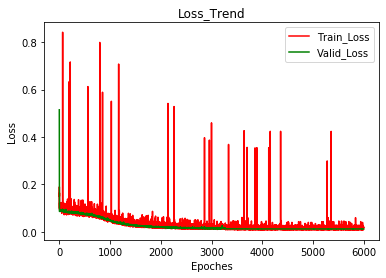

In [39]:
# #print(device)
from time import time
TRAN_TAG = True
if TRAN_TAG:
    if path.exists("model/trajectory_predict_25_4_30.pt"):
        Prednet.load_state_dict(torch.load('model/trajectory_predict_25_4_30.pt'))
    Prednet = Prednet.double()
    Prednet = Prednet.to(device)
    start = time()
    trainIters(Prednet, 1000,0.001,20)
    print('Training time is:',time()-start,'s')

In [121]:
def calcu_XY(predY):
    #input: [batchsize len features]; features:[velx,vely,x,y]
    '''
    deltaY = v0*delta_t + 0.5* a *delta_t^2
    a = (v - v0)/delta_t
    vo
    '''
    vels = predY[:,:,0:2]
    rst_xy = np.zeros(predY[:,:,0:2].shape)
    rst_xy[:,:-predict_length,:] = predY[:,:-predict_length,2:4]
    delta_t = 0.1
   
    for i in range(predict_length):
        a = (vels[:,-(predict_length-i),:] - vels[:,-(predict_length+1-i),:])/delta_t
        delta_xy = vels[:,-(predict_length-i),:]*vels[:,-(predict_length-i),:]-vels[:,-(predict_length+1-i),:]*vels[:,-(predict_length+1-i),:]
        delta_xy = delta_xy/(2*a)
        rst_xy[:,-(predict_length-i),:] = rst_xy[:,-(predict_length+1-i),:] + delta_xy
    return rst_xy

In [122]:
def Eval_net(encoder,optmizer=False):
    n_trajectory_batch = 0
    loss = []
    MSE_pres = []
    MSE_rsts = []
    for local_batch, local_labels in Test:
        n_trajectory_batch = n_trajectory_batch + 1
        criterion = nn.MSELoss()
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)
        predY = encoder(local_batch[:,:,:-1])
        #print(WholeSet.std.repeat(BatchSize,100,1).shape)
        test_loss = criterion(predY,local_labels)
        loss.append(test_loss.item())
        std = WholeSet.std.repeat(local_batch.shape[0],x.shape[1],1)
        std = std[:,:,:4].to(device)
        mn = WholeSet.mn.repeat(local_batch.shape[0],x.shape[1],1)
        mn = mn[:,:,:4].to(device)
        rg = WholeSet.range.repeat(local_batch.shape[0],x.shape[1],1)
        rg = rg[:,:,:4].to(device)
        predY = (predY*(rg*std)+mn).detach().cpu()
        pY = np.array(predY )
        pY =  scipy.signal.savgol_filter(pY, window_length=((x.shape[1]-11)//2)*2+1, polyorder=3,axis=1)
        local_labels = (local_labels*(rg*std)+mn).detach().cpu()
        Y = np.array(local_labels)
        pY[:,:-predict_length,:] = Y[:,:-predict_length,:]
        rst_xy = calcu_XY(pY)
        
        if n_trajectory_batch > 20:
            break
        for i in range(1):
            #plt.figure(i)
            #plt.xlim(0,80)
            #plt.ylim(0,2000)
            #plt.subplot(4,5,n_trajectory_batch)
            #  plt.plot(pY[i,:,2],pY[i,:,3],'r',label='prediction')
            real_predict = torch.from_numpy(Y[:,-predict_length-1:,2:4])
            rst_predict = torch.from_numpy(rst_xy[:,-predict_length-1:,:2])
            pre_predict = torch.from_numpy(pY[:,-predict_length-1:,2:4])
            MSE_pre = criterion(real_predict,pre_predict)
            MSE_rst = criterion(real_predict,rst_predict)
           
            MSE_pres.append(MSE_pre.item())
            MSE_rsts.append(MSE_rst.item())
            print("MSE RST:",MSE_rst.item())
            print("MSE pre:",MSE_pre.item())
            plt.plot(Y[i,:-predict_length,2],Y[i,:-predict_length,3],'r',label = 'history trajectory')
            if optmizer:
                 plt.plot(rst_xy[i,-predict_length-1:,0],rst_xy[i,-predict_length-1:,1],'b',label=" prediction trajectory via optimizing")
            plt.plot(pY[i,-predict_length-1:,2],pY[i,-predict_length-1:,3],'k',label='prediction trajectory')
            plt.plot(Y[i,-predict_length-1:,2],Y[i,-predict_length-1:,3],'g',label='Real trajectory')
            plt.title('Trajectory prediction')
            plt.xlabel('X ')
            plt.ylabel('Y ')
            plt.legend()
            if optmizer:
                plt.savefig("image/trajectory_output_nobehavior/trajectory_no_behavior{}.svg".format(n_trajectory_batch),dpi=600)
            else:
                plt.savefig("image/trajectory_output/trajectory_no_behavior{}.svg".format(n_trajectory_batch),dpi=600)
        plt.show()
        print('Test loss:',test_loss.item())
    print("mean MSE pre:",np.mean(MSE_pres))
    print("mean MSE rst:",np.mean(MSE_rsts))
    print('average loss:',np.mean(loss))

MSE RST: 2.2488028242447387
MSE pre: 4.939292828218196


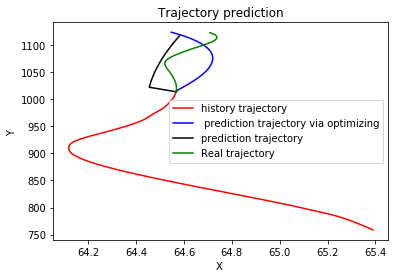

Test loss: 0.012973111374869149
MSE RST: 1.8647647152783755
MSE pre: 3.403763068321959


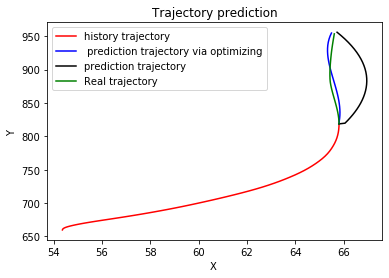

Test loss: 0.009648179085250348
MSE RST: 2.730838056838117
MSE pre: 4.428241535668938


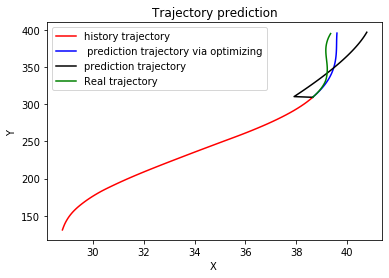

Test loss: 0.009950964657187781
MSE RST: 2.052927948226257
MSE pre: 4.321427505865282


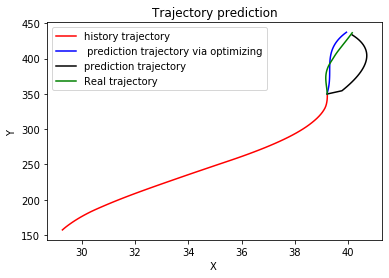

Test loss: 0.010203953884865464
MSE RST: 2.5040536426759457
MSE pre: 4.86441573240573


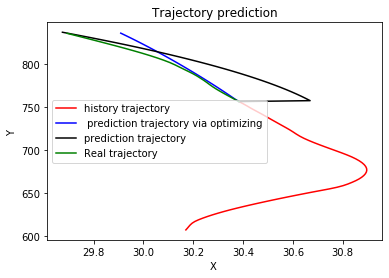

Test loss: 0.013787536570038181
MSE RST: 2.800453516530041
MSE pre: 4.467989174100763


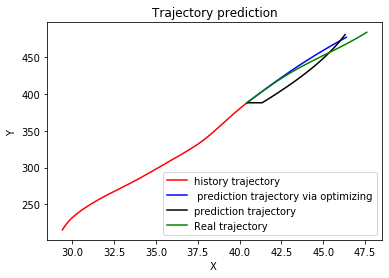

Test loss: 0.013769588857311794
MSE RST: 2.538210506273205
MSE pre: 3.841408989286046


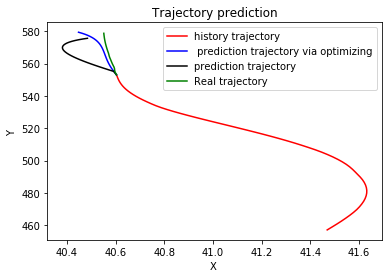

Test loss: 0.010996419987324613
MSE RST: 2.8406646093051164
MSE pre: 4.985617709806127


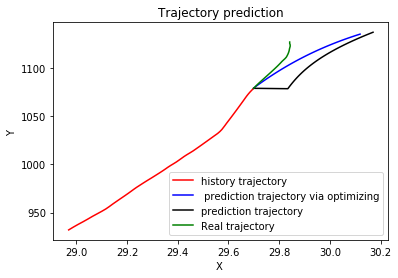

Test loss: 0.013221169589602053
MSE RST: 2.585724911195877
MSE pre: 4.224181688649264


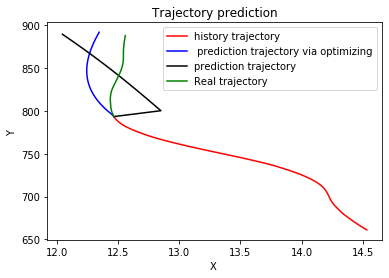

Test loss: 0.011808909381545007
MSE RST: 2.0680056290548494
MSE pre: 4.822927515478248


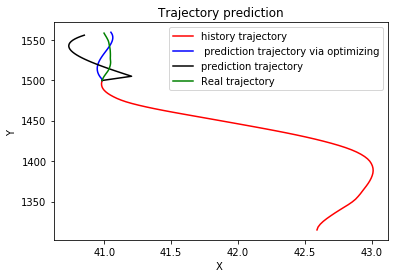

Test loss: 0.012437450245076738
MSE RST: 2.4226594565167097
MSE pre: 4.512616054450406


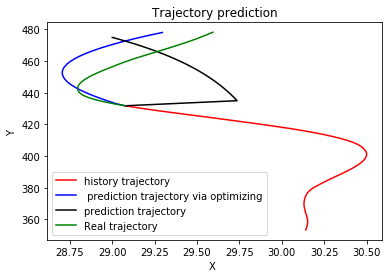

Test loss: 0.010205167066472995
MSE RST: 1.9729183545902242
MSE pre: 3.78455208876152


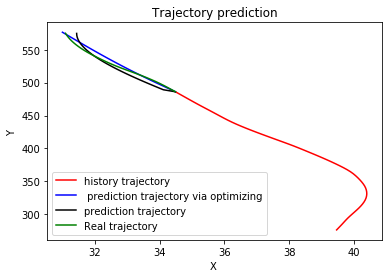

Test loss: 0.009606218571632073
MSE RST: 2.1304538220309324
MSE pre: 3.4174992005587272


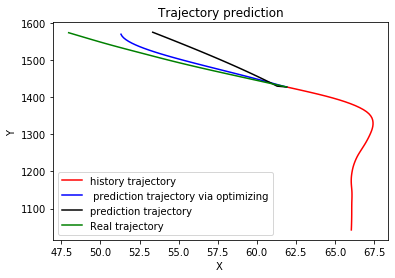

Test loss: 0.01291898708326963
MSE RST: 2.9192913981912527
MSE pre: 4.142614712197319


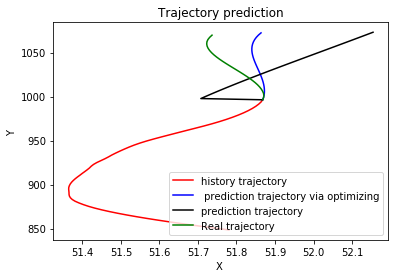

Test loss: 0.01082573519052252
mean MSE pre: 4.296896271697753
mean MSE rst: 2.405697813639403
average loss: 0.011596670824640597


In [123]:
hidden_size = 256
Prednet = NNPred(x.shape[2]-1, y.shape[2],hidden_size, x.shape[0])
Prednet.load_state_dict(torch.load('model/trajectory_predict_25_4_30.pt'))
Prednet = Prednet.double()
Prednet = Prednet.to(device)
Prednet.eval()
Eval_net(Prednet,True)

In [129]:
def predict(model,test_load,n,optimizer=False):
    test = iter(test_load)
    x,y =  test.next()
    x,y = x.to(device),y.to(device)
    predY = model(x[:,:,:-1])
    criterion = nn.MSELoss()
    test_loss = criterion(predY,y)
    std = WholeSet.std.repeat(x.shape[0],x.shape[1],1)
    std = std[:,:,:4].to(device)
    mn = WholeSet.mn.repeat(x.shape[0],x.shape[1],1)
    mn = mn[:,:,:4].to(device)
    rg = WholeSet.range.repeat(x.shape[0],x.shape[1],1)
    rg = rg[:,:,:4].to(device)
    predY = (predY*(rg*std)+mn).detach().cpu()
    pY = np.array(predY)
    pY =  scipy.signal.savgol_filter(pY, window_length=((x.shape[1]-1)//2)*2+1, polyorder=3,axis=1)
    local_labels = (y*(rg*std)+mn).detach().cpu()
    Y = np.array(local_labels)
    pY[:,:-predict_length,:] = Y[:,:-predict_length,:]
    rst_xy = calcu_XY(pY)
    #rst_xy =  scipy.signal.savgol_filter(rst_xy, window_length=31, polyorder=3,axis=1)
    #rst_xy[:,-30:-1,:]=  scipy.signal.savgol_filter(rst_xy[:,-30:-1,:], window_length=51, polyorder=3,axis=0)
    real_predict = torch.from_numpy(Y[:n,-predict_length-1:,2:4][0])
    rst_predict = torch.from_numpy(rst_xy[:n,-predict_length-1:,:2][0])
    pre_predict = torch.from_numpy(pY[:n,-predict_length-1:,2:4][0])
    MSE_pre = criterion(real_predict,pre_predict)
    MSE_rst = criterion(real_predict,rst_predict)
    print("MSE pre:",MSE_pre.item())
    print("MSE RST:",MSE_rst.item())
    plt.plot(Y[:n,:-predict_length,2][0],Y[:n,:-predict_length,3][0],'r',label = 'history trajectory')
    if optimizer:
        plt.plot(rst_xy[:n,-predict_length-1:,0][0],rst_xy[:n,-predict_length-1:,1][0],'b',label="prediction trajectory via optimizing")
    plt.plot(pY[:n,-predict_length-1:,2][0],pY[:n,-predict_length-1:,3][0],'k',label='prediction trajectory')
    plt.plot(Y[:n,-predict_length-1:,2][0],Y[:n,-predict_length-1:,3][0],'g',label='Real trajectory')
    plt.title('Trajectory prediction')
    plt.xlabel('X ')
    plt.ylabel('Y ')
    plt.legend()
    if optimizer:
        plt.savefig("image/trajectory_output_nobehavior/trajectory_nobehavior_alone1.svg",dpi = 600)
    else:
        plt.savefig("image/trajectory_output/trajectory_nobehavior_alone.svg",dpi = 600)
    
    print("Test Loss:",test_loss.item())

MSE pre: 1.186739221730884
MSE RST: 0.18550666036772717
Test Loss: 0.012080282251882974


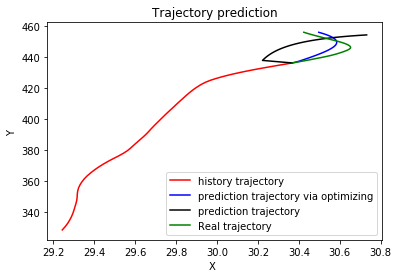

In [134]:
hidden_size = 256
Prednet = NNPred(x.shape[2]-1, y.shape[2],hidden_size, x.shape[0])
Prednet.load_state_dict(torch.load('model/trajectory_predict_25_4_30.pt'))
Prednet = Prednet.double()
Prednet = Prednet.to(device)
Prednet.eval()
predict(Prednet,Test,1,True)

In [53]:
test_iter = iter(Test)
x, y = test_iter.next()
print(x.shape)
x,y = x[:,:,:-1].to(device),y.to(device)
x = x[0][0].view(-1,len(x[0][0])).unsqueeze(0)
predY = Prednet(x)
print(predY)
print(y[0][30])

torch.Size([128, 100, 26])
tensor([[[ 0.4872, -0.4533,  0.7231, -0.1353]]], device='cuda:0',
       dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-2.4385, -0.3009,  0.2197, -0.0358], device='cuda:0',
       dtype=torch.float64)
